--- 
Microeconometrics | Summer 2021 | M.Sc. Economics, Bonn University 

# Replication of Angrist, J., and Evans, W. (1998). "Children and Their Parent's Labor Supply: Evidence from Exogenous Variation in Family Size". <a class="tocSkip">   

[Carolina Alvarez Garavito](https://github.com/carolinalvarez)

 

------------------------------------------------------------------

This notebook contains the replication of: **Angrist, J.D., & Evans, W.N. (1998).** [Children and Their Parents' Labor Supply: Evidence from Exogenous Variation in Family Size](https://www.jstor.org/stable/116844?seq=1). *The American Economic Review*, 88(3). 450-477.

The construction of the samples for the 1980 census data and the replication of tables 6 and 7 are based on the program files provided by the authors [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/11288). For all the other estimations, I tried to follow the specifications provided by the authors in the published paper as closely as possible. For all the estimations that were not as precise as the authors' results, I tried to provide an explanaition under *Note*. The only tables not replicated are Table 1 (since it uses the raw 1980 and 1990 census data not published by the authors) and Table 13 (since it does not belong to the core results of Angrist and Evans (1998)).

My independent contribution based on the research of Angrist and Evans (1998) can be found in the section [Extensions on Angrist and Evans (1998) using 1980 Census Extracts](#extensions) of this notebook. 

# Table of contents
* [Introduction](#Introduction)
* [Identification Strategy](#iden)
* [Empirical Methodology](#Empirical-Methodology)
    * [Casual estimation with a Binary IV](#binary)
    * [V Estimation as LATE Estimation](#late)
* [Replication Angrist & Evans (1998)](#Replication-of-Angrist-&-Evans-(1998))
    * [Data, descriptive statistics and first stage relationships](#Data,-Descriptive-Statistics-and-First-Stage-Relationships)
        * [Data & Descriptive Statistics](#data-descriptives)
    * [Fertility and Labor Supply](#fertility)
        * [Wald Estimates](#wald)
        * [Two-stage least-square estimation](#2sls)
        * [2SLS Results](#2sls-results)
        * [Other Specification Issues](#specifications)
        * [Heterogeneity in the Impact of Children on Labor Supply](#heteroge)
    * [Comparison with estimates using multiple births](#comparison)
* [Extensions on Angrist and Evans (1998) using 1980 Census Extracts](#extensions)
    * [Extension I: Exploration on the probability of additional childbearing conditional to women's education](#extension1)
    * [Extension II: Causal Forest application for an alternative estimation of heterogeneity effects](#extension2)
        * [CATE estimations for subgroups on women's education](#extension2-1)
        * [Simulations to show convergence of the estimations of the CATE](#extension2-2)
        * [Discussion of the results and comparison to Angrist and Evans (1998)](#extension2-3)
    * [Extension III: Testing for selection on unobservables or "violation of exclusion restriction"](#extension3)
* [Conclusions](#conclusions)
* [Appendix: Variable Dictionary](#apendix)
        
    

In [1]:
%matplotlib inline
!pip install linearmodels
!pip install stargazer
!pip install econml
import numpy as np
import pandas as pd
import pandas.io.formats.style
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm_api
from linearmodels.iv import IV2SLS
import matplotlib as plt
import matplotlib.pyplot as plt
import pickle
import copy
from IPython import display
from IPython.display import HTML
from stargazer.stargazer import Stargazer
from statsmodels.api import add_constant
from functools import reduce
from sklearn.model_selection import train_test_split
from econml.grf import CausalIVForest

In [2]:
from auxiliary.auxiliary_data_preparation import ( 
    data_preparation_1980,
    data_preparation_1990,
    get_data_all_women_1980,
    get_data_all_women_1990,
    data_preparation_married_couples,
    data_preparation_married_couples_1990,
    rename_interactions_earnings,
    families_one_more_kid
)

from auxiliary.auxiliary_statistics import ( 
    table_sum_stats,
    table_sum_stats_husbands, 
    Table_3_panel_1,
    Table_3_panel_2,
    difference_means
)

from auxiliary.auxiliary_plots import ( 
    plot_distribution
)

from auxiliary.auxiliary_regressions import ( 
    OLS_Regressions_more2k,
    OLS_Labor_Supply_Models,
    OLS_Labor_Supply_Interactions_wifes,
    OLS_Labor_Supply_Interactions_husbands,
    OLS_Labor_Supply_First_Stage_wifes,
    OLS_Labor_Supply_First_Stage_husbands,
    IV_Labor_Supply_Interactions,
    mean_samples,
    IV_Comparison_Models,
    mean_differences_instruments,
    mean_differences_instruments_90,
    wald_estimates_regressions
)

---
# Introduction 
---

Angrist and Evans (1998) study the causal mechanisms between fertility and the work effort of both men and women. The authors begin by explaining the theoretical and practical reasons of studying the relationship between fertility and labor supply. First, there has been development of economic models that link the family and the labor market. Second, the relationship between fertility and labor supply could explain the increase of women's participation in the labor market in the post-war period, where having fewer children could have increased the female labor-force share. Meanwhile, other studies have linked fertility with female withdraws from the labor market and lower wages compared to men.

The mayority of empirical studies related to childbearing and labor supply find a negative correlation between family size (i.e., fertility) and female labor force. However, in his assesment of Economics of the Family, Robert J. Willis argues that there has not been well-measured exogenous variables that allow to separate cause and effect relationships from correlations among variables such as delay of marriage, decline of childbearing, increase in divorces, and increase in female labor force participation.

In this vein, the authors argue that the problems concerning the causal association between family size and labor supply arises from the theoretical argument that both factors are jointly determinated. For example, some labor-supply econometric models often use child-status variables as regressors on hours of work. On the other hand, economic demographers usually measure the effect of wages on fertility. According to the authors, "*since fertility variables cannot be both dependent and exogenous at the same time, it seems unlikely that either sort of regression has a causal interpretation*".

To tackle this endogeneity problem, the authors then use an instrumental variable approach and construct an instrument for fertility using the sex composition of the first two kids within a household (same sex). The instrument is totally randomly assigned, since the sex composition of the first two kids is assigned by chance. This leads to a scenario of a natural experiment for estimating the effect of childbearing on labor supply outcomes for women.

# Identification Strategy <a class="anchor" id="iden"></a>

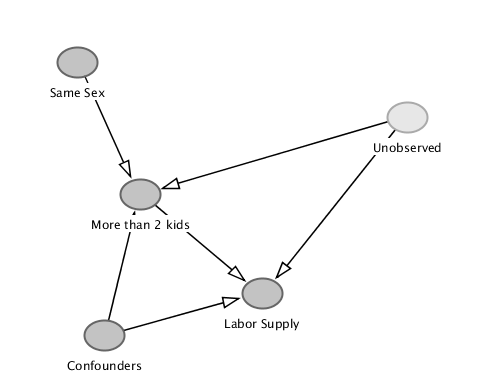

In [10]:
display.Image("files/causal_graph_v2.png")

As explained before, fertility might suffer from an endogeneity problem and therefore, inferencing a causal effect of fertility on labor outcomes might suffer from omitted variable bias. Angrist and Evans (1998) contribute to the empirical discussion about the effect of childbearing on labor supply by finding an instrument based on the sex-mix of children in families with two or more kids. It is argued in the paper that this captures parental preferences for mixed-sex siblings, where parents of same-sex children are much more likely to have an additional child. For example, in a household with two boys as first two children, it is likely that the parents will decide to have an additional child, hopefully a girl. Since the sex-mix assigment of the first two children is completly random, the authors argue that the instrument obeys both relevancy and exogeneity assumptions.

To summarize:

**Endogeneity Problem**

Measuring fertility by using the total number of births suffer from an endogeneity problem and omitted variable bias, since we do not observe the preferences and other determinants of childbearing among women and marriages. 

**Instrument** 

Dummy variable for whether the sex of the second child matches the sex of the first child

In this way, the authors find a way to estimate the variation on Y (labor-supply outcomes) caused by D (treatment, in this case, having more than 2 children) generated by the variation of Z (same sex composition of first two kids) that is independent from its association with Y through D (see causal graph above). Co-founders in the model of Angrist and Evans (1998) are a vector of demographic variables that affect both Y and D, which the authors then use as control variables in their regression estimations.

---
# Empirical Methodology

## Casual estimation with a Binary IV <a class="anchor" id="binary"></a>

Since the instrumental variable *same sex* is binary (that means, it takes the value of 1 when the household has a same sex child composition and zero otherwise), I therefore discuss the methodology as described in Morgan and Winship (2007).

Following the causal equation:

\begin{equation}
Y = \alpha + \delta D + \epsilon
\end{equation}

where Y is the outcome variable, D the assigment of treatment and $\delta$ the causal effect of D on Y. When D is endogenous, we could take a Z variable (instrument) to estimate the variation of D  on Y generated by the variation of Z to estimate the causal effect of D on Y. In order to do so, the instrument has to have an association with Y independently from its association with Y though D. This is violeated when Z and Y share common causes. The instrumental variable *same sex* follows this because it has an association with Y but this association do not have unobserved cofounders given the random nature of the instrument.

Formally:

\begin{equation}
E[Y] = E[\alpha + \delta D + \epsilon]= \alpha + \delta E[D] + E[\epsilon]
\end{equation}

We re-write it as a **difference equation in Z and divide both sides by $ E[D|Z=1] - E[D|Z=0]$** which yields:

\begin{equation}
\frac{E[Y|Z=1]-E[Y|Z=0]}{E[D|Z=1]-E[D|Z=0]} =\frac{\delta (E[D|Z=1]-E[D|Z=0]) + (E[\epsilon|Z=1]-E[\epsilon|Z=0])}{E[D|Z=1]-E[D|Z=0]}
\end{equation}

If the data holds for the causal graph despicted above, then $Z$ has no association with $ /epsilon$ and therefore:

\begin{equation}
\frac{E[Y|Z=1]-E[Y|Z=0]}{E[D|Z=1]-E[D|Z=0]} =\delta
\end{equation}

Under these conditions, the ratio of the population-level association between Y and Z and between D and Z is equal to the causal effect of D on Y. Then, if $Z$ is associated with $D$ but not with $/upvarepsilon$, then the following is the IV-Estimator for infinite samples:

\begin{equation}
\hat{\delta}_{IV,WALD} = \frac{E_N[y_i|z_i=1] - E_N[y_i|z_i=0]}{E_N[d_i|z_i=1] - E_N[d_i|z_i=0]}
\end{equation}

This is the IV-Estimator, which is known as the Wald Estimator when the instrument is binary. The wald estimator takes the average difference in the observed outcome of those who were exposed to the instrumental variable and of those who were not. Then it takes the average difference between the ones in the treatment group who took the treatment and those in the tratment group who did not receive the treatment.



## IV Estimation as LATE Estimation <a class="anchor" id="late"></a>

Imbends and Angrist (1994) developed a framework for classifiying individuals as: i) those who respond positively to an instrument; ii) those who remain unaffected by the instrument; iii) those who rebel against the instrument. When $D$ and $Z$ are binary variables, then they are four possible group of individuals:

| Status                                    |Potential treatment assignment         | 
| ------------------------------------------|:-------------------------------------:| 
| Compliers ($\tilde{C}=c$)                 | $D^{Z=0}=0; D^{Z=1}=1$                | 
| Defiers ($\tilde{C}=d$)                   | $D^{Z=0}=1 D^{Z=1}=0$                 | 
| Always takers ($\tilde{C}=a$)             | $D^{Z=0}=1 D^{Z=1}=1$                 |  
| Never takers ($\tilde{C}=n$)              | $D^{Z=0}=0 D^{Z=1}=0$                 |   


A valid instrument $Z$ for the casual effect of $D$ on $Y$ must satisfy three assumptions in order to identify the **LATE**:

* Independence assumption: ($Y^{1}, Y^{0}, D^{Z=1}, D^{Z=0} {\perp\!\!\!\perp} Z$)

This is analogous to the assumption that $cov(Z, \varepsilon)=0$ in the traditinal IV litera
* Non-zero effect of instrument assumption: $k \neq 0$ for all $i$
* Monotonicity assumption: either $k \geq 0$ for all $i$ or $k \leq 0$ for all $i$ 

If these three asumptions hold, then an instrument Z identifies the LATE (Local Average Treatment Effect) or "*the average causal effect of the treatment for the subset of the population whose treatment selection is induced by the instrument*" (Morgan and Winship, 2007). If $k \geq 0$ $\forall i$, then the Wald estimator converges to a particular LATE:

\begin{equation}
\hat{\delta}_{IV,WALD} \overset{p}{\to} \ E[\delta| \tilde{C}=c]
\end{equation}

which is an average causal effect among compliers. In contrast, if $k \leq 0$ $\forall i$, then the Wald estimator converges to the opposite LATE:

\begin{equation}
\hat{\delta}_{IV,WALD} \overset{p}{\to} \ E[\delta| \tilde{C}=d]
\end{equation}

the average causal effect among defiers. However, in both cases, the treatment effects for the groups never takers and always takers are in any way estimated by the IV.

---

---
# Replication of Angrist & Evans (1998)
---

## I. Data, Descriptive Statistics and First Stage Relationships <a class="anchor" id="Data,-Descriptive-Statistics-and-First-Stage-Relationships"></a>

### A. Data & Descriptive Statistics <a class="anchor" id="data-descriptives"></a>

Angrist and Evans (1998) use two extracts from the Census Public Use Micro Samples(PUMS) that correspond to the year 1980 and 1990 respectively. The Census contains information on labor supply, the sex of mother's first two children, an indicator of multiple births and other demographic variables.

However, there is no retrospective fertility information in the PUMS data sets other than the total number of children ever born. That means, the census does not track children across households. The authors thus matched children to mothers within households accordingly to the following strategy: they attached people in a household labeled as *child* to a female householder or the spouse of a male householder. They deleted any mother for whom the number of children in the household did not match the total amount of children ever born. Also, in households with multiple families, relationship codes and subfamily identifiers were used to pair children with mothers.

The sample is then limited to mothers aged 21-35 whose oldest child was less than 18 years old at the time of the Census. There are two main reasons to restrict the data in such fashion. First, few women younger than age 21 have two children, thus taking into account younger women will decrease the number of observations for the instrumental variable *more than two children* . Second, a child over 18 is very likely to have moved to a different household. It is very unlikely that a woman aged 35 years old at the time of the census has a child 18 year old or more. Thus, restricting the sample to women aged 35 or less assures that the two children are still living in the household and therefore, still be financially dependent from their parents.

For the empirical analysis, the authors use two samples for each year of census. The first includes all women (after restricting the sample to mothers aged 21-35) with two or more children and with first children not being younger than one year old. The second sample includes only married women. This dataset is then used to test the main theories of household production (e.g., Gronau, 1973) and exploring the impact of children as well on father's labor supply.

The following table summarizes the samples created by the authors and used for the empirical analysis:


| Year        | Sample        | Description                                                            |
| :----       | :----         |:----                                                                   |
| 1980        | Full sample   | Woman with two or more children, age 21-35 years old                   |
|             | Married sample| Couples married at time of census, only once and at time of first birth|                   
| 1990        | Full sample   | Woman with two or more children, age 21-35 years old                   |            
|             |Married sample | Woman married at time of census                                        |                                

Variables with information on timing of first marriage and the number of marriages is not available in the 1990 PUMS; thereore, for building the 1990 married sample, only the variable wheter the woman was married at the time of the census is considered.

In [3]:
census_1_1980 = pd.read_stata("data/m_d_806_1.dta")
census_2_1980 = pd.read_stata("data/m_d_806_2.dta")
data_1980=census_1_1980.append(census_2_1980, ignore_index=False, verify_integrity=False, sort=False)
data_1980.replace(np.nan, 0, inplace=True)
data_1980=data_preparation_1980(data_1980)

In [7]:
census_1_1990 = pd.read_stata("data/m_d_903_1.dta")
census_2_1990 = pd.read_stata("data/m_d_903_2.dta")
census_3_1990 = pd.read_stata("data/m_d_903_3.dta")
data_1990=census_1_1990.append([census_2_1990, census_3_1990], ignore_index=False, verify_integrity=False, sort=False)
data_1990.replace(np.nan, 0, inplace=True)
data_1990=data_preparation_1990(data_1990)

---
<span style="color:coral">**NOTE**:</span> The original data provided by the authors can be found [here](https://economics.mit.edu/faculty/angrist/data1/data/angev98). For this replication the data is split into several .dta-files due to GitHub size constraints.

---

In [12]:
data_1980.describe()

,const,STATE,SEXK,AGEK,QTRBKID,RACEK,SPANISH,BIRTHPLK,SCHOOLK,GRADE,...,workedm,workedd,more1k,more2k,more3k,yobd,ageqm,ageqd,agefstm,agefstd
count,927267.0,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,...,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,927267.00000,927267.000000,927267.000000,927267.000000
mean,1.0,28.463958,0.488175,8.758242,2.522137,1.575727,0.148400,48.795570,0.956873,5.507927,...,0.609795,0.799311,0.706559,0.270864,0.270864,51.112147,125.32954,114.301683,22.198787,19.441823
std,0.0,15.381372,0.499860,4.764916,1.113425,2.055951,0.610885,112.210375,0.685231,4.391520,...,0.487796,0.400516,0.455339,0.444406,0.444406,14.896428,24.59747,59.061507,4.363212,14.380762
min,1.0,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-11.000000,78.00000,0.000000,2.500000,-17.750000
25%,1.0,17.000000,0.000000,5.000000,2.000000,1.000000,0.000000,17.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,42.000000,107.00000,103.000000,19.000000,19.500000
50%,1.0,29.000000,0.000000,9.000000,3.000000,1.000000,0.000000,30.000000,1.000000,5.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,47.000000,124.00000,129.000000,21.500000,23.500000
75%,1.0,41.000000,1.000000,13.000000,4.000000,1.000000,0.000000,42.000000,1.000000,9.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,54.000000,141.00000,150.000000,24.500000,27.250000
max,1.0,56.000000,1.000000,17.000000,4.000000,13.000000,4.000000,997.000000,3.000000,22.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,80.000000,241.00000,362.000000,57.250000,83.500000


In [13]:
data_1990.describe()

,const,SEX2NDK,MULTI2ND,AGE2NDK,ASEX2ND,AAGE2ND,SEXK,RACEK,AGEK,PWGTK1,...,faminc_log,nonmomi,nonmomi_log,workedm,workedd,more1k,more2k,more3k,agefstm,agefstd
count,974693.0,974693.000000,974693.000000,974693.000000,974693.00000,974693.000000,974693.000000,974693.000000,974693.000000,974693.000000,...,974693.000000,974693.000000,974693.000000,974693.000000,974693.000000,974693.000000,974693.000000,974693.000000,974693.000000,974693.000000
mean,1.0,0.334271,0.007809,4.531268,0.00675,0.003069,0.487855,5.535981,8.694282,19.565310,...,10.415585,38034.902415,9.493284,0.726220,0.759468,0.683686,0.230369,0.230369,24.255096,19.378223
std,0.0,0.471735,0.088021,4.717114,0.08188,0.055310,0.499853,29.605802,4.812785,9.541281,...,1.356394,39007.452765,2.776896,0.445897,0.427407,0.465037,0.421069,0.421069,4.873531,15.964262
min,1.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,-33423.524000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,-17.000000
25%,1.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,5.000000,13.000000,...,10.110967,14360.800000,9.572258,0.000000,1.000000,0.000000,0.000000,0.000000,21.000000,19.000000
50%,1.0,0.000000,0.000000,3.000000,0.00000,0.000000,0.000000,1.000000,9.000000,19.000000,...,10.653420,30950.000000,10.340128,1.000000,1.000000,1.000000,0.000000,0.000000,24.000000,25.000000
75%,1.0,1.000000,0.000000,8.000000,0.00000,0.000000,1.000000,1.000000,13.000000,25.000000,...,11.062834,49520.000000,10.810132,1.000000,1.000000,1.000000,0.000000,0.000000,27.000000,29.000000
max,1.0,1.000000,1.000000,17.000000,1.00000,1.000000,1.000000,327.000000,17.000000,165.000000,...,13.825033,767555.048000,13.550965,1.000000,1.000000,1.000000,1.000000,1.000000,59.000000,85.000000


In [14]:
data_1980.head()

,const,STATE,SEXK,AGEK,QTRBKID,RACEK,SPANISH,BIRTHPLK,SCHOOLK,GRADE,...,workedm,workedd,more1k,more2k,more3k,yobd,ageqm,ageqd,agefstm,agefstd
0,1.0,1,1,9,3,1,0,1,1,6,...,1,1,1,0,0,40.0,142,158.0,26.00,30.00
1,1.0,1,1,8,3,1,0,1,2,5,...,1,1,0,0,0,40.0,149,159.0,28.75,31.25
2,1.0,1,0,9,1,1,0,1,1,5,...,0,1,1,0,0,44.0,109,143.0,18.25,26.75
3,1.0,1,0,5,2,1,0,1,1,2,...,1,0,1,0,0,80.0,100,0.0,19.25,-5.75
4,1.0,1,1,11,1,1,0,1,1,7,...,1,1,1,0,0,51.0,119,115.0,18.75,17.75


In [15]:
data_1990.head()

,const,SEX2NDK,MULTI2ND,AGE2NDK,ASEX2ND,AAGE2ND,SEXK,RACEK,AGEK,PWGTK1,...,faminc_log,nonmomi,nonmomi_log,workedm,workedd,more1k,more2k,more3k,agefstm,agefstd
0,1.0,0.0,0.0,12.0,0.0,0.0,1,1,16,12,...,10.825710,28013.464,10.240441,1,1,1,0,0,19,19.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0,1,14,12,...,10.851058,51588.698,10.851058,0,1,0,0,0,29,36.0
2,1.0,0.0,0.0,8.0,0.0,0.0,0,1,9,19,...,10.732414,41762.692,10.639759,1,1,1,0,0,33,38.0
3,1.0,1.0,0.0,10.0,0.0,0.0,1,1,11,15,...,11.054920,63254.372,11.054920,0,1,1,0,0,22,27.0
4,1.0,1.0,0.0,13.0,0.0,0.0,1,1,15,23,...,11.837481,103677.548,11.549041,1,1,1,0,0,27,24.0


In [4]:
data_all_women_1980=get_data_all_women_1980(data_1980)
print("The sample of all women for 1980 aged between 21 and 35 with second kid no older than 1 year old has", len(data_all_women_1980), "observations.")

The sample of all women for 1980 aged between 21 and 35 with second kid no older than 1 year old has 394840 observations.


In [8]:
data_all_women_1990=get_data_all_women_1990(data_1990)
print("The sample of all women for 1990 aged between 21 and 35 with second kid no older than 1 year old has", len(data_all_women_1990), "observations.")

The sample of all women for 1990 aged between 21 and 35 with second kid no older than 1 year old has 380007 observations.


In [5]:
data_all_women_1980=data_preparation_married_couples(data_all_women_1980)

In [6]:
#creating the sample for married couples 1980

msample_1980=data_all_women_1980[(data_all_women_1980['TIMESMAR']==1) & (data_all_women_1980['MARITAL']==0) & (data_all_women_1980['illegit']==0) & (data_all_women_1980['agefstd']>=15) &
            (data_all_women_1980['agefstm']>=15) & (data_all_women_1980["AGED"]!=np.NaN)]

print("The sample of married couples has", len(msample_1980), "observations.")

The sample of married couples has 254652 observations.


In [9]:
data_all_women_1990=data_preparation_married_couples_1990(data_all_women_1990)

In [10]:
#creating the sample for married couples 1990

msample_1990=data_all_women_1990[(data_all_women_1990['MARITAL']==0) & (data_all_women_1990['agefstd']>=15) &
            (data_all_women_1990['agefstm']>=15) & (data_all_women_1990["AGED"]!=np.NaN)]

print("The sample of married couples for 1990 has", len(msample_1990), "observations.")

The sample of married couples for 1990 has 301595 observations.


Besides from the **main samples** of **all women** and **married women**, the authors contruct subsamples to later compute estimates of labor supply with interaction terms using: i) the earnings distribution of husbads; ii) wife's education; this is, whether a married women has less than a highschool degree, a highschool degree or more than a highschool degree. Also, for the replication of Table 3, there is the need to construct the samples of married women who have at least one kid of each sample of all women and married women. These samples are constructed below. 

In [16]:
#Creating sample of only middle income husbands 1980
sample_middle_third=msample_1980[msample_1980["husband_distribution"]=="middle_third"].copy()

print("The sample of married couples whos husband belongs to the middle income distribution has", len(sample_middle_third), "observations.")

The sample of married couples whos husband belongs to the middle income distribution has 95549 observations.


In [17]:
#Creating sample of only middle income husbands 1990
sample_middle_third_1990=msample_1990[msample_1990["husband_distribution"]=="middle_third"].copy()

print("The sample of married couples whos husband belongs to the middle income distribution for the 1990 Census has", len(sample_middle_third_1990), "observations.")

The sample of married couples whos husband belongs to the middle income distribution for the 1990 Census has 123641 observations.


In [18]:
sample_middle_third=rename_interactions_earnings(sample_middle_third)

In [19]:
sample_middle_third_1990=rename_interactions_earnings(sample_middle_third_1990)

In [20]:
#Samples of moms by education 1980
sample01=msample_1980[msample_1980["lessgrad"]==1]
sample02=msample_1980[msample_1980["hsgrad"]==1]
sample03=msample_1980[msample_1980["moregrad"]==1]

In [21]:
#Samples of moms by education 1990
sample04=msample_1990[msample_1990["lessgrad"]==1]
sample05=msample_1990[msample_1990["hsgrad"]==1]
sample06=msample_1990[msample_1990["moregrad"]==1]

In [22]:
data_all_women_1980_one=families_one_more_kid(data_1980)
data_all_women_1980_one=data_preparation_married_couples(data_all_women_1980_one)

In [23]:
data_all_women_1990_one=families_one_more_kid(data_1990)

In [24]:
msample_1980_one=data_all_women_1980_one[(data_all_women_1980_one['TIMESMAR']==1) & (data_all_women_1980_one['MARITAL']==0) & (data_all_women_1980_one['illegit']==0) & (data_all_women_1980_one['agefstd']>=15) &
            (data_all_women_1980_one['agefstm']>=15) & (data_all_women_1980_one["AGED"]!=np.NaN)]

In [25]:
msample_1990_one=data_all_women_1990_one[(data_all_women_1990_one['MARITAL']==0) & (data_all_women_1990_one['agefstd']>=15)
                                         & (data_all_women_1990_one['agefstm']>=15) & (data_all_women_1990_one["AGED"]!=np.NaN)]

**Extension: Plots for husband's earnings distribution** 

In the original paper, Angrist and Evans (1998) explore the heterogeneity impact of children on Labor supply. For this, they report the estimates of the effect of *more than two chilren* on **married women**, conditional on the position of the husband in the husband's earnings distribution. They assign each husband to whether him belongs to the upper third, middle third or lower third of the husband's earnings distribution.  However, the authors do not explicitly mention in the paper how they perform the splitting of the earnings distribution of husbands. Here, I plot the total income of husbands to visualize the distribution. I also plot the bins after constructing the husband earnings sample by separating the distribution into three quartiles.

Husbands earnings distribution, married sample 1980 census data
mean of distribution 38918.90166170163


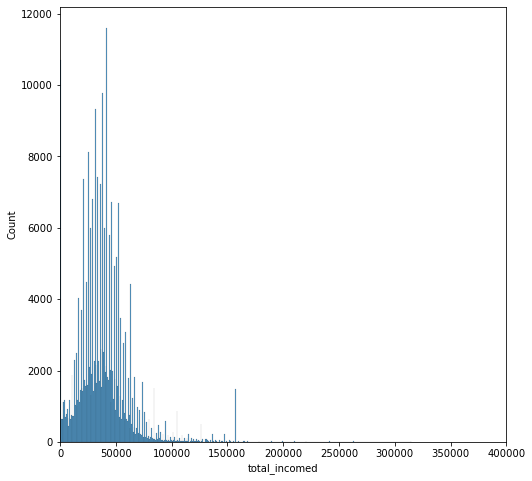

In [84]:
plot_distribution(msample_1980, "total_incomed")
print("Husbands earnings distribution, married sample 1980 census data")
print("mean of distribution", msample_1980["total_incomed"].mean())

outliers in husbands earnings distribution, married sample 1980 census data


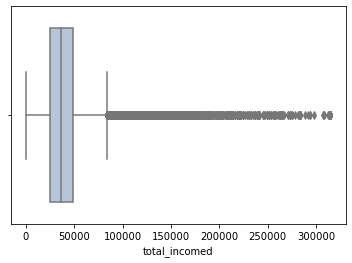

In [86]:
sns.boxplot(x=msample_1980['total_incomed'], color="lightsteelblue")
print("outliers in husbands earnings distribution, married sample 1980 census data")

Observations in each bin of husbands earnings distribution, married sample 1980 census data


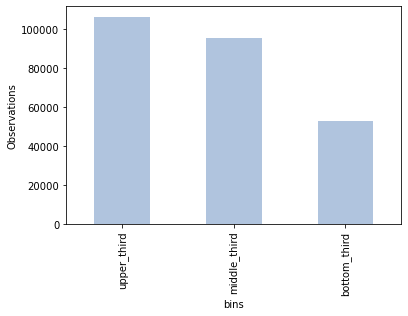

In [83]:
msample_1980['husband_distribution'].value_counts().plot(kind='bar', color="lightsteelblue", xlabel="bins", ylabel="Observations")
print("Observations in each bin of husbands earnings distribution, married sample 1980 census data")

#### **Table 2| Part 1: Descriptive Statistics, Women aged 21-35 with 2 or more children - 1980 PUMS**

Descriptive statistics and variable definitions for covariates, intruments and dependent variables are given in Table 2 from Angrist and Evans (1998) and replicated in the code below. 

Table 2 part 1 provides information on statistics and variable definition for covariates, instruments and dependent variables later used in the empirical analysis for the 1980 census data, while Table 2 part 2 provides the same information for 1990 census data. 

The covariate of main interest is *more than two children* and the first instrumental variable for this covariate is *same sex*, described as if the first two children were the same gender. The table also shows the two components of *same sex*, which are *two boys* and *two girls*. Just as stated in Angrist and Evans (1998), among all the women who already had a second child, 40.2 percent had a third, where the correspoding fraction for the 1990 sample is 37 percent. For both samples, around 50% of all the families with two childs have children of the same gender and above 51% of first births correspond to a boy.

Meanwhile, another instrument used in the empirical analysis correspond to multiple births, or *twins*. In the 1980 PUMS, multiple births is constructed as siblings who have the same age and quarter of birth (note: for the construction of this indicator, the age of the second and third child was used; this means, the twin birth corresponds to the mother's second birth). For the 1980 PUMS, the mean of *twins* is 0.09 for the sample of all women and 0.08 for the sample of married women. Since the variable quarter of birth is not reported for the 1990 PUMS dataset, the multiple birth variable was defined as children who have the same age.

Demographic variables include: mother's age, age at first birth, years of education, and indicators for race and ethnic background. 

The labor-supply variables are based on Census questions on *Worked for pay, weeks worked, hours/week, labor income (annual)*. The last two variables in the table measure Family income and a variable called non-wife income which measures the overall family income minus the wife's labor income. The descriptive statistics show that women's labor force participation, weeks and hours worked increased between 1980 and 1990.

In [26]:
#Table 2 for 1980
table1_1=table_sum_stats(data_all_women_1980)
table1_2=table_sum_stats(msample_1980)
table1_3=table_sum_stats_husbands(msample_1980)
data_frames = [table1_1, table1_2, table1_3]
Table2_1980 = reduce(lambda  left,right: pd.merge(left,right,on=['Variable'],
                                            how='left'), data_frames)

Table2_1980.rename(columns = {'Mean_x':'All women (mean)', 
                       'Std. Dev._x':'All women (std.dev)',
                       'Mean_y':'Married women (mean)',
                      'Std. Dev._y':'Married women (std.dev)',
                      'Mean':'Husbands (mean)',
                      'Std. Dev.':'Husbands (std.dev)'}, 
            inplace = True)

Table2_1980=Table2_1980[["Variable", "All women (mean)", "All women (std.dev)", "Married women (mean)", "Married women (std.dev)", 'Husbands (mean)', "Husbands (std.dev)"]]
Table2_1980 = Table2_1980.replace(np.nan, '-', regex=True)

print("The sample of all women for 1980 has", len(data_all_women_1980), "observations, while the sample for married couples has" , len(msample_1980), "observations")
Table2_1980

The sample of all women for 1980 has 394840 observations, while the sample for married couples has 254652 observations


,Variable,All women (mean),All women (std.dev),Married women (mean),Married women (std.dev),Husbands (mean),Husbands (std.dev)
0,Children ever born,2.552,0.808,2.508,0.769,-,-
1,More than two children,0.402,0.490,0.381,0.486,-,-
2,First child was a boy,0.511,0.500,0.514,0.500,-,-
3,Second child was a boy,0.511,0.500,0.512,0.500,-,-
4,First two children were boys,0.264,0.441,0.266,0.442,-,-
5,First two children were girls,0.242,0.428,0.239,0.427,-,-
6,First two children were the same sex,0.505,0.500,0.505,0.500,-,-
7,Second birth was a twin,0.009,0.092,0.008,0.091,-,-
8,Age,30.125,3.510,30.393,3.386,33.035,4.564
9,Age at first birth,20.515,2.938,21.216,2.904,24.352,3.989


**Table 2| Part 2: Descriptive Statistics, Women aged 21-35 with 2 or more children - 1990 PUMS**

In [27]:
#Table 2 for 1990
table1_1=table_sum_stats(data_all_women_1990)
table1_2=table_sum_stats(msample_1990)
table1_3=table_sum_stats_husbands(msample_1990)
data_frames = [table1_1, table1_2, table1_3]
Table2_1990 = reduce(lambda  left,right: pd.merge(left,right,on=['Variable'],
                                            how='left'), data_frames)

Table2_1990.rename(columns = {'Mean_x':'All women (mean)', 
                       'Std. Dev._x':'All women (std.dev)',
                       'Mean_y':'Married women (mean)',
                      'Std. Dev._y':'Married women (std.dev)',
                      'Mean':'Husbands (mean)',
                      'Std. Dev.':'Husbands (std.dev)'}, 
            inplace = True)

Table2_1990=Table2_1990[["Variable", "All women (mean)", "All women (std.dev)", "Married women (mean)", "Married women (std.dev)", 'Husbands (mean)', "Husbands (std.dev)"]]
Table2_1990 = Table2_1990.replace(np.nan, '-', regex=True)
print("The sample of all women for 1990 has", len(data_all_women_1990), "observations, while the sample for married couples has" , len(msample_1990), "observations")
Table2_1990

The sample of all women for 1990 has 380007 observations, while the sample for married couples has 301595 observations


,Variable,All women (mean),All women (std.dev),Married women (mean),Married women (std.dev),Husbands (mean),Husbands (std.dev)
0,Children ever born,2.495,0.767,2.477,0.747,-,-
1,More than two children,0.370,0.483,0.363,0.481,-,-
2,First child was a boy,0.513,0.500,0.514,0.500,-,-
3,Second child was a boy,0.511,0.500,0.512,0.500,-,-
4,First two children were boys,0.264,0.441,0.265,0.441,-,-
5,First two children were girls,0.240,0.427,0.238,0.426,-,-
6,First two children were the same sex,0.504,0.500,0.503,0.500,-,-
7,Second birth was a twin,0.018,0.131,0.016,0.127,-,-
8,Age,30.434,3.463,30.658,3.339,33.461,4.764
9,Age at first birth,21.809,3.487,22.278,3.459,25.08,4.695


#### Table 3: Fraction of Families that had another child by parity and sex of children

Table 3 reports estimates of the impact of child sex and the sex mix on fertility. I have divided the table into two panels for each census data's samples.

The first panel of Table 3 shows the sex preferences in families with *more than one children* and it shows the fraction of women with at least one kid who had a second one, conditional on the sex of the first child. The third row shows the difference by sex. It is shown, for 1980 and 1990 data, that there is almost non difference, with the biggest difference captured by the 1990 census data all women sample. However, even in this case, the impact of the sex of the first child in fertility is very low. 


In [28]:
Table3_1_1=Table_3_panel_1(data_all_women_1980_one)
Table3_1_2=Table_3_panel_1(msample_1980_one)
Table3_2_1=Table_3_panel_2(data_all_women_1980)
Table3_2_2=Table_3_panel_2(msample_1980)

keys = ['All women, PUMS 1980', 'Married women, PUMS 1980']
frames1 = [Table3_1_1, Table3_1_2]
frames2 = [Table3_2_1, Table3_2_2]
table3_1 = pd.concat(frames1, axis=1, keys=keys) 
table3_2 = pd.concat(frames2, axis=1, keys=keys)

Table3_1_3=Table_3_panel_1(data_all_women_1990_one)
Table3_1_4=Table_3_panel_1(msample_1990_one)
Table3_2_3=Table_3_panel_2(data_all_women_1990)
Table3_2_4=Table_3_panel_2(msample_1990)

keys = ['All women, PUMS 1990', 'Married women, PUMS 1990']
frames1 = [Table3_1_3, Table3_1_4]
frames2 = [Table3_2_3, Table3_2_4]
table3_3 = pd.concat(frames1, axis=1, keys=keys) 
table3_4 = pd.concat(frames2, axis=1, keys=keys)

In [29]:
table3_1

All women, PUMS 1980  \
                                                     Fraction of sample   
Sex of first child in families with one or more...                        
(1) one girl                                                   0.511534   
(2) one boy                                                    0.488466   
difference (2) - (1)                                                NaN   

                                                                                    \
                                                   Fraction that had another child   
Sex of first child in families with one or more...                                   
(1) one girl                                                              0.688577   
(2) one boy                                                               0.688733   
difference (2) - (1)                                                      0.000156   

                                                   Married women, PUMS 1980  \
                                                         Fraction of sample   
Sex of first child in families with one or more...                            
(1) one girl                                                       0.514948   
(2) one boy                                                        0.485052   
difference (2) - (1)                                                    NaN   

                                                                                    
                                                   Fraction that had another child  
Sex of first child in families with one or more...                                  
(1) one girl                                                              0.713986  
(2) one boy                                                               0.713519  
difference (2) - (1)                                                     -0.000467

In [30]:
table3_3

All women, PUMS 1990  \
                                                     Fraction of sample   
Sex of first child in families with one or more...                        
(1) one girl                                                   0.511506   
(2) one boy                                                    0.488494   
difference (2) - (1)                                                NaN   

                                                                                    \
                                                   Fraction that had another child   
Sex of first child in families with one or more...                                   
(1) one girl                                                              0.666246   
(2) one boy                                                               0.669218   
difference (2) - (1)                                                      0.002972   

                                                   Married women, PUMS 1990  \
                                                         Fraction of sample   
Sex of first child in families with one or more...                            
(1) one girl                                                       0.513675   
(2) one boy                                                        0.486325   
difference (2) - (1)                                                    NaN   

                                                                                    
                                                   Fraction that had another child  
Sex of first child in families with one or more...                                  
(1) one girl                                                              0.700094  
(2) one boy                                                               0.702045  
difference (2) - (1)                                                      0.001952

The second panel of table 3 shows the relationship between the fraction of women who have a third child and the sex of hers first two children. The first three rows document the fraction of women who had 1) one girl and one boy as the two first children, 2) whether the two kids were two boys, and 3) whether the first two kids were two girls. The last two rows show the fraction who had a same sex composition in the first birth and the difference between the same-sex and the mixed-sex group averages. 

The results for both datasets (1980 and 1990 PUMS) show that women with two children of the same sex are much more likely to have a 3rd child in comparison with women who had one girl and one boy as the first couple of children. For example, in the 1990 all women sample, 40,17% of women who had a same-sex child composition as first two kids had another child afterwards. In comparison, 33,86% of women who had a mixed-sex composition had a third child. On the other hand, the data suggest that the relationship between sex composition and probability of having a third child is slighly higher for married couples, where the difference between same and mixed-sex composition is approximatly 7%. 

In [31]:
table3_2

All women, PUMS 1980  \
                                                     Fraction of sample   
Sex of first child in families with two or more...                        
(1) one girl one boy                                            0.49461   
(2) two boys                                                   0.263719   
(3) two girls                                                   0.24167   
(4) both same sex                                               0.50539   
Difference (4) - (1)                                                  -   

                                                                                    \
                                                   Fraction that had another child   
Sex of first child in families with two or more...                                   
(1) one girl one boy                                                      0.371971   
(2) two boys                                                              0.422686   
(3) two girls                                                             0.441150   
(4) both same sex                                                         0.431515   
Difference (4) - (1)                                                      0.059544   

                                                   Married women, PUMS 1980  \
                                                         Fraction of sample   
Sex of first child in families with two or more...                            
(1) one girl one boy                                               0.494652   
(2) two boys                                                       0.266073   
(3) two girls                                                      0.239276   
(4) both same sex                                                  0.505348   
Difference (4) - (1)                                                      -   

                                                                                    
                                                   Fraction that had another child  
Sex of first child in families with two or more...                                  
(1) one girl one boy                                                      0.346742  
(2) two boys                                                              0.403831  
(3) two girls                                                             0.424637  
(4) both same sex                                                         0.413683  
Difference (4) - (1)                                                      0.066941

In [32]:
table3_4

All women, PUMS 1990  \
                                                     Fraction of sample   
Sex of first child in families with two or more...                        
(1) one girl one boy                                           0.495738   
(2) two boys                                                    0.26389   
(3) two girls                                                  0.240372   
(4) both same sex                                              0.504262   
Difference (4) - (1)                                                  -   

                                                                                    \
                                                   Fraction that had another child   
Sex of first child in families with two or more...                                   
(1) one girl one boy                                                      0.338696   
(2) two boys                                                              0.396869   
(3) two girls                                                             0.407114   
(4) both same sex                                                         0.401752   
Difference (4) - (1)                                                      0.063056   

                                                   Married women, PUMS 1990  \
                                                         Fraction of sample   
Sex of first child in families with two or more...                            
(1) one girl one boy                                               0.497173   
(2) two boys                                                       0.264713   
(3) two girls                                                      0.238114   
(4) both same sex                                                  0.502827   
Difference (4) - (1)                                                      -   

                                                                                    
                                                   Fraction that had another child  
Sex of first child in families with two or more...                                  
(1) one girl one boy                                                      0.327660  
(2) two boys                                                              0.391816  
(3) two girls                                                             0.403529  
(4) both same sex                                                         0.397362  
Difference (4) - (1)                                                      0.069702

**Table 4: Difference in means for demographic variables by same sex and twins 2**

The authors argue that the random assigment of *same sex* makes it very likely that reduced-form regressions of fertility and labor supply outcomes on the instruments have a causal interpretation. For testing this, the paper compares the mean of demographic characteristics of people who have same-sex and mixed-sex siblings composition. That is, the demographic characteristics of the treated and untreated sample. I then compare the variables listed in Angrist and Evans for these samples in the code below. The differences are computed on the all women samples for 1980 and 1990.

In [11]:
dem_var_1980=["AGEM", "agefstm", "blackm", "whitem", "otheracem", "hispm", "educm"]
dem_var_1990=["AGEM", "agefstm", "blackm", "whitem", "otheracem", "hispm", "YEARSCHM"]
Table4_80_1=difference_means(data_all_women_1980, dem_var_1980, "same_sex")
Table4_80_2=difference_means(data_all_women_1980, dem_var_1980, "twins")
Table4_90=difference_means(data_all_women_1990, dem_var_1990, "same_sex")
Table4_90.index=Table4_80_1.index
Table4=pd.concat([Table4_80_1, Table4_90, Table4_80_2], axis=1, keys=["By same sex-1980", "By same sex-1990", "By twins-1980"])
Table4

By same sex-1980           By same sex-1990            \
                  Mean difference Std. err.  Mean difference Std. err.   
demographic_vars                                                         
AGEM                      -0.0162    0.0112           0.0146    0.0112   
agefstm                    0.0165    0.0094          -0.0128    0.0113   
blackm                     0.0003    0.0010           0.0021    0.0010   
whitem                     0.0003    0.0012          -0.0004    0.0013   
otheracem                 -0.0003    0.0011           0.0007    0.0013   
hispm                     -0.0000    0.0005          -0.0003    0.0002   
educm                     -0.0031    0.0076           0.0095    0.0075   

                   By twins-1980            
                 Mean difference Std. err.  
demographic_vars                            
AGEM                      0.2561    0.0589  
agefstm                   0.2081    0.0510  
blackm                    0.0307    0.0062  
whitem                   -0.0216    0.0069  
otheracem                 0.0260    0.0065  
hispm                    -0.0043    0.0027  
educm                     0.0893    0.0417

The replicated results vary somehow with the ones on Angrist and Evans (1998). However, for same sex 1980 and 1990, none of these differences are statistically different from zero at a 5% percent level and the coefficients appear to be very small. That means, the differences in demographic variables when the samples are splitted into treatment and untreatment using same sex as instrument are small and insignificant. However, for the twins samples, the difference seem to be larger. For example, it seems like twins are more likely for older women (AGEM) and black women. 

## II. Fertility and Labor Supply <a class="anchor" id="fertility"></a> 

### A. Wald Estimates <a class="anchor" id="wald"></a>

The authors argue that the sex composition of siblings (i.e., same sex) is *randomly assigned*. That means that reduced-form regressions of fertility and labor supply outcomes on the instruments have a causal interpretation. In this section, the authors show how statistical techniques can be used to ilustrate how the sex-mix strategy identifies the effect of fertility on both mom and dad's labor supply.

They consider the following equation:

\begin{equation}
y_{i} = \alpha + \beta x_{i} + \varepsilon_{i},
\end{equation}

where $y_{i}$ is a measure of labor supply and $x_{i}$ is the endogenous fertility measure. In the case of Angrist and Evans (1998), they measure labor supply through the following variables: worked per pay, weeks worked, hours worked, total income, and family income. For married couples, this also might include non-wife income. The endogenous variable for fertility measure is more than 2 kids. 

Let's denote $z_{i}$ as the binary instrument *same sex*. Then, the IV estimate of $\beta$ is:

\begin{equation}
\beta_{IV} =  \frac{(\bar{y_{1}} - \bar{y_{0}})}{(\bar{x_{1}} - \bar{x_{0}})}
\end{equation}

where $\bar{y_{1}}$ is the mean of $y_{i}$ for those observations with $z_{i}=1$ and other terms are similarly defined. The IV estimator attributes any effect of $z_{i}$ on $y_{i}$ to the effect of $z_{i}$ on $x_{i}$ (see causal graph). One important feature of the model stated on the paper is that following Guido W. Imbens and Angrist (1994), the $\beta_{IV}$ can be interpreted as a Local Average Treatment Effect (LATE) specific to the instrument $z_{i}$. In this case then, the estimator measures the average effect of $x_{i}$ on $y_{i}$ for individuals whose fertility has been affected by their children's sex mix measured by same sex.

Table 5 reports Wald Estimates of Labor-Supply Models for the 1980 PUMS and 1990 PUMS all women samples when same sex is used as an instrument. For the calculation of the Wald Estimates when twins is used as instrument, the authors only use the 1980 PUMS dataset. For computational reasons, I have splitted Table 5 into two parts: the first part shows the difference in means by instrument and the second part calculates the wald estimate using as covariates more 2 kids and number of children. The results replicated here are extremly close to the ones reported in Angrist and Evans (1998).

**Table 5 | Part 1: Difference in meands by Instrument**

The first two rows of Table 5 Part 1 concentrates on estimating the denominator of the Wald Estimate.The results show that the effect of same sex instrument on more than 2 children is 0.0059 for in 1980 and 0.063 in 1990. The effect of same sex on number of children is 0.075 in 1980 and 0.084 in 1990. For the census data of 1980, the effect of the twin instrument on the probability of having a third child is 0.60 and the effects of twins on number of children is 0.81. 

After the first two rows, the authors calculate the nominator of the Wald estimate for alternative labor supply outcomes using same sex as instrument. These results show that women with two children of the same sex have a lower probability of working (-0.079), work less hours per year (-0.30) and work fewer weeks per year (-0.37). Also, they have lower annual earnings and lower family income.

In [33]:
outcomes_means=["more2k", "KIDCOUNT", "workedm", "WEEKSM", "HOURSM", "total_incomem", "faminc_log"]
Table5_means_1980=mean_differences_instruments(data_all_women_1980, outcomes_means)
Table5_means_1990=mean_differences_instruments_90(data_all_women_1990, outcomes_means)
Table5_part1=pd.concat([Table5_means_1980, Table5_means_1990], axis=1, keys=["1980 PUMS", "1990 PUMS"])
Table5_part1

1980 PUMS                                     \
              Mean difference by Same Sex Std. err. Mean difference by twins   
outcomes                                                                       
more2k                             0.0595    0.0016                   0.6031   
KIDCOUNT                           0.0754    0.0026                   0.8114   
workedm                           -0.0079    0.0016                  -0.0458   
WEEKSM                            -0.3787    0.0709                  -1.9760   
HOURSM                            -0.3089    0.0602                  -1.9523   
total_incomem                   -130.3005   34.3881                -560.3765   
faminc_log                        -0.0015    0.0043                  -0.0374   

                                          1990 PUMS            
               Std.err. Mean difference by Same Sex Std. err.  
outcomes                                                       
more2k           0.0008                      0.0631    0.0016  
KIDCOUNT         0.0118                      0.0837    0.0025  
workedm          0.0086                     -0.0055    0.0015  
WEEKSM           0.3790                     -0.3119    0.0742  
HOURSM           0.3196                     -0.2369    0.0619  
total_incomem  186.3776                   -105.2232   41.9951  
faminc_log       0.0248                     -0.0080    0.0046

**Table 5 | Part 2: Wald Estimates with covariates**

The second part of Table 5 reports the Wald estimates when $x_{i}$ is either more than 2 children or number of children. For the case of more than 2 children in the 1980 PUMS, the results show that having a third kid will reduce labor supply in -13.2 percentage points, weeks worked in about 6.4 weeks and hours of work per week in 5.18. The loss in income is -2188 US Dollars (very close to -2200 reported in Angrist and Evans). The replicated results also support the findings in the original paper that results for 1990 PUMS are also negative but somehow smaller, with the exception of the effect on family income, which is larger than 1980. 

The results for when number of children is used puts these effects in *per-child terms* and are a bit smaller for each year. The coefficients for when twins are used as instrument are relatively smaller than same sex instrument and later on the authors do a comparison of the difference of this instruments. Furthermore, the authors argue that the difference in outcomes for more than 2 kids and number of children is a proportional factor of 0.75. Thus, they chose to estimate coefficients for the effect of more than 2 children as endogenous regressor since it captures the effect induced by either instrument: same-sex composition of the first two kids and second-birth twins.

In [34]:
outcomes_wald_1980=["workedm", "WEEKSM", "HOURSM", "total_incomem", "faminc_log"]
Table5_1=wald_estimates_regressions(data_all_women_1980, outcomes_wald_1980, "same_sex")
Table5_2=wald_estimates_regressions(data_all_women_1980, outcomes_wald_1980, "twins")
outcomes_wald_1990=["workedm", "WEEKSM", "HOURSM", "total_incomem", "faminc_log"]
Table5_3=wald_estimates_regressions(data_all_women_1990, outcomes_wald_1990, "same_sex")
Table5_part2=pd.concat([Table5_1, Table5_2, Table5_3], axis=1, keys=["Wald Estimates-Same sex 1980 PUMS", "Wald Estimates-Twins 1980 PUMS", "Wald Estimates-Same sex 1990 PUMS"])
Table5_part2

Wald Estimates-Same sex 1980 PUMS                               \
                           More than 2 children Std. err. Number of children   
outcomes                                                                       
workedm                                  -0.132     0.026             -0.104   
WEEKSM                                   -6.360     1.191             -5.022   
HOURSM                                   -5.187     1.011             -4.096   
total_incomem                         -2188.305   577.549          -1728.163   
faminc_log                               -0.024     0.072             -0.019   

                       Wald Estimates-Twins 1980 PUMS            \
              Std.err.           More than 2 children Std. err.   
outcomes                                                          
workedm          0.021                         -0.076     0.014   
WEEKSM           0.941                         -3.276     0.638   
HOURSM           0.799                         -3.237     0.542   
total_incomem  456.106                       -929.162   309.461   
faminc_log       0.057                         -0.062     0.039   

                                          Wald Estimates-Same sex 1990 PUMS  \
              Number of children Std.err.              More than 2 children   
outcomes                                                                      
workedm                   -0.056    0.011                            -0.087   
WEEKSM                    -2.435    0.474                            -4.947   
HOURSM                    -2.406    0.403                            -3.757   
total_incomem           -690.642  230.021                         -1668.729   
faminc_log                -0.046    0.029                            -0.127   

                                                     
              Std. err. Number of children Std.err.  
outcomes                                             
workedm           0.024             -0.065    0.018  
WEEKSM            1.177             -3.728    0.887  
HOURSM            0.982             -2.831    0.740  
total_incomem   666.013          -1257.525  501.896  
faminc_log        0.074             -0.096    0.055

### B. Two-stage Least - Squares Estimation <a class="anchor" id="2sls"></a>

In this section, the authors discuss and compare two-stage least-squares (2SLS) and ordinary least-squares (OLS). In particular, the authors are interested in the following equation:

**Equation 4**
\begin{equation}
    y_i = \alpha_{0}\prime w_i + \alpha_1 s_{1i} +  \alpha_2 s_{2i}  + \beta x_i + \varepsilon_i 
\end{equation}

where $w_i$ is a vector of demographic variables-includes exogenous cofounders such as mother's age, age at first birth and race indicator-, $s_{1}$ and $s_{2}$ are indicators for whether the first child is a boy or second child is a boy and $x_i$ stands for the endogenous regressor. 

The first-stage equation relating more than 2 children to same sex is:

**Equation 5**
\begin{equation}
    x_i = \phi_{0}\prime w_i + \phi_1 s_{1i} +  \alpha_2 s_{2i}  + \lambda \ same \ sex_i + \eta_i 
\end{equation}

where $\lambda$ is the first-stage effect of the instrument. Because of same sex is actually made out of two components- two boys and two girls- there is another identification strategy that can be implemented by using these two components as instruments. In this case, the equation of interest has to drop either $s_1i$ or $s_2i$ because of multicolinearity:

**Equation 6**
\begin{equation}
    y_i = \alpha_{0}\prime w_i + \alpha_1 s_{1i}  + \beta x_i + \varepsilon_i 
\end{equation}

The first-stage relationship between $x_i$ and sex mix is then:

**Equation 7**
\begin{equation}
    x_i = \phi_{0}\prime \ w_i + \phi_1 \ s_{1i} +  \lambda_0 \ two \ boys_i + \lambda_1 \ two \ girls_i + \eta_i 
\end{equation}

### C. 2SLS Results <a class="anchor" id="2sls-results"></a>

Table 6 of Angrist and Evans (1998) reports the first stage relationship between sex mix measured by same sex and two-boys/two-girls and fertility measured by more than 2 kids for all women and married women samples in 1980 and 1990 PUMS. Because of the size of the tables, I also splitted Table 6 into two parts: First part shows the results for 1980 samples and the second part does the same for 1990 samples. 

For each part: column (1) shows the estimates of the simple regression of same sex on more than 2 kids; column (2) estimates equation 5; column (3) estimates equation 7; columns (4), (5) and (6) do the same for married women samples. The coefficients of interest are:

* boy1st
* boy2nd
* same_sex
* two_boys
* two_girls

The results replicated in this notebook are very similar to the original ones presented in Angrist and Evans (1998). 

---
**Table 6 Part 1: OLS Estimates of *More than 2 children* equations for 1980 PUMS**

Table 6 part 1 show the first-stage results for 1980 all women and married women samples. The coefficients reveal that for the sample of all women, women who have a same-sex kids composition are 6.12 percentage points more likely to have a third child in a model with covariates, where the correspondent estimate for the married women sample is 6.89 percentage points. The probability of having a third child when having two boys as first two childs is 5.25%, whereas two girls 6.99%. These coefficients are a bit larger for married women.

In [41]:
OLS_Regressions_more2k(data_all_women_1980, msample_1980)

**Table 6 Part 2: OLS Estimates of *More than 2 children* equations for 1990 PUMS**

In [40]:
OLS_Regressions_more2k(data_all_women_1990, msample_1990)

---
**Table 7: OLS and 2SLS Estimates of Labor-Supply model 1980 Census Data**

Table 7 reports estimates of OLS estimates and 2SLS estimates (this one using same sex and two boys/two girls) as instruments. I followed the specifications of the authors, where the exogenous regressors of the model are the same as in Table 6, but the coefficients are not reported inside the table. Also, in models with more than 1 instrument, the variable boy2nd is dropped to avoid multicollinearity problems. The models are estimated for all women, married women and husbands of married women. The table show only the coefficient for more than 2 children of each estimated model. 

For the IV estimates, the authors argue that the estimates can be interpreted as a LATE (for further details, refer to the explanation on the section Empirical Methodology).

**OLS Estimates**

Following what the authors find in the original paper, OLS estimates for all women and married women suggest that having a third child reduces the probability of being at the labor market (measured by worked for pay). This estimate is -0.177 for the sample of all women and -0.167 for married women, which means that the presence of a third child reduces the probability of working by around 17% points. About weeks worked, the estimates for all women are also negative (-8.99) and somehow greater than for married women (-8.04). Family income falls about 13% and the effecton total income for women is -3,768 for the sample of all women, whereas for the married sample this is -3,148. 

In contrast with the findings for women, the effect of more than 2 children on labor supply outcomes are small for husbands. For example, OLS estimates for the effect of a third child on worked for pay is -0.008 and estimates for weeks worked are -0.901. An interesting finding is that the coefficient for hours worked per week is positive for men and the coefficient on labor income is smaller relative to women.

**IV Estimates**

The replicated IV estimates using same sex as instrument for the sample of all women are very close to the original findinds. The coefficient on worked for pay is -0.117, weeks worked -5.5, hours worked -4.5, total income -1,900. The estimates for IV are smaller than the estimates from OLS regressions, which suggests that OLS tends to exaggerate the effect of more kids on labor supply outcomes. On the other hand, IV estimates on workedd (worked for pay) for husbands reflect almost no effect of an increase in number of kids on these outcomes, in contrast to the small but significate finding in the OLS estimate.

---
<span style="color:coral">**Note**:</span> Husband's coefficients differ from the original findings in Angrist and Evans (1998). This could be due to the issue discussed above, were the income distribution for dads/husbands present certain outliers that the authors might have solved bu dropping those observations.

---

For each model, the outcomes and controls will be different because the authors want to measure labor supply outcomes for moms and dads. Also, for the IV models, the variable boy2nd is dropped from the covariate vector to avoid multicollinealty. In the following code, I define the different dependent variables and controls, and then apply a function that replicates table 7.

In [35]:
outcomes_labor_supply_moms=["workedm", "WEEKSM", "HOURSM", "total_incomem", "faminc_log", "nonmomi_log"]
outcomes_labor_supply_dads=["workedd", "WEEKSD", "HOURSD", "total_incomed", "faminc_log", "nonmomi_log"]
controls_OLS_moms = ["const", "more2k", 'AGEM', 'agefstm', "boy1st", "boy2nd", "blackm", "hispm", "otheracem"]
controls_IV_1_moms=["const", 'AGEM', 'agefstm', "boy1st", "boy2nd", "blackm", "hispm", "otheracem"]
controls_IV_2_moms=["const", 'AGEM', 'agefstm', "boy1st", "blackm", "hispm", "otheracem"]
controls_OLS_dads = ["const", "more2k", 'AGED', 'agefstd', "boy1st", "boy2nd", "blackd", "hispd", "otheraced"]
controls_IV_1_dads=["const", 'AGED', 'agefstd', "boy1st", "boy2nd", "blackd", "hispm", "otheraced"]
controls_IV_2_dads=["const", 'AGED', 'agefstd', "boy1st", "blackd", "hispd", "otheraced"]

In [36]:
Table7_1=OLS_Labor_Supply_Models(data_all_women_1980, outcomes_labor_supply_moms, controls_OLS_moms, controls_IV_1_moms, controls_IV_2_moms)
Table7_2=OLS_Labor_Supply_Models(msample_1980, outcomes_labor_supply_moms, controls_OLS_moms, controls_IV_1_moms, controls_IV_2_moms)
Table7_3=OLS_Labor_Supply_Models(msample_1980, outcomes_labor_supply_dads, controls_OLS_dads, controls_IV_1_dads, controls_IV_2_dads)

keys=["All women", "Married Women", "Husbands"]
frames=[Table7_1, Table7_2, Table7_3]
Table7=pd.concat(frames, axis=1, keys=keys)
Table7 = Table7.replace(np.nan, '-', regex=True)
Table7

All women                                          \
                OLS (1) Std.err (1) IV-same sex (2) Std.err (2)   
workedm          -0.177       0.002          -0.117       0.025   
WEEKSM           -8.998       0.072          -5.548       1.117   
HOURSM           -6.667       0.062          -4.536       0.953   
total_incomem   -3768.2      35.391        -1900.04      546.19   
faminc_log       -0.137       0.004          -0.026       0.068   
nonmomi_log       0.208       0.008           0.113       0.121   
workedd               -           -               -           -   
WEEKSD                -           -               -           -   
HOURSD                -           -               -           -   
total_incomed         -           -               -           -   

                                                     Married Women  \
              IV-two girls, two boys (3) Std.err (3)       OLS (1)   
workedm                            -0.11       0.025        -0.167   
WEEKSM                            -5.252        1.11        -8.044   
HOURSM                            -4.298       0.946         -5.99   
total_incomem                   -1810.25     542.853       -3148.3   
faminc_log                        -0.034       0.068         -0.14   
nonmomi_log                        0.075       0.121        -0.062   
workedd                                -           -             -   
WEEKSD                                 -           -             -   
HOURSD                                 -           -             -   
total_incomed                          -           -             -   

                                                       \
              Std.err (1) IV-same sex (2) Std.err (2)   
workedm             0.002          -0.117       0.028   
WEEKSM              0.089          -5.252       1.217   
HOURSM              0.075          -4.763       1.022   
total_incomem      42.068        -1270.72     573.312   
faminc_log          0.004          -0.045       0.059   
nonmomi_log         0.005           0.033       0.071   
workedd                 -               -           -   
WEEKSD                  -               -           -   
HOURSD                  -               -           -   
total_incomed           -               -           -   

                                                     Husbands              \
              IV-two girls, two boys (3) Std.err (3)  OLS (1) Std.err (1)   
workedm                           -0.109       0.028        -           -   
WEEKSM                            -5.014       1.208        -           -   
HOURSM                            -4.531       1.014        -           -   
total_incomem                   -1254.12     569.842        -           -   
faminc_log                        -0.049       0.059    -0.16       0.004   
nonmomi_log                        0.022        0.07   -0.084       0.005   
workedd                                -           -   -0.008       0.001   
WEEKSD                                 -           -   -0.901       0.044   
HOURSD                                 -           -    0.152       0.052   
total_incomed                          -           - -1763.01     103.695   

                                                                      \
              IV-same sex (2) Std.err (2) IV-two girls, two boys (3)   
workedm                     -           -                          -   
WEEKSM                      -           -                          -   
HOURSM                      -           -                          -   
total_incomem               -           -                          -   
faminc_log             -0.045        0.06                     -0.051   
nonmomi_log             0.032       0.071                      0.019   
workedd                 0.004       0.009                      0.001   
WEEKSD                  0.593       0.601                      0.408   
HOURSD                  0.525       0.

---
**Table 8: OLS and 2SLS Estimates of Labor Supply Models using 1990 Census Data**

The results for 1990 Census Data are quite similar to the ones found in 1980 Census Data. The authors find a significant difference, however, and this is a higher impact on married women's earnings for the year 1990 that could be due to an increase in women's earnings. The authors suggest that the reason women present higher wages is because of the age at which they are having children; Table 2 shows that the mean of age of first birth increased between 1980 and 1990 from aproximatly 21 to 22, thus having additional work experience might result in higher wages.

---
<span style="color:coral">**Note**:</span> Wife's coefficients differ from the original findings in Angrist and Evans (1998) for the year 1990, as well as husband's earnings. This could be explain by the fact that the authors transform these variables by deflacting them for US 1995 dollars. For year 1980, the replication code stated the deflactor rate; however, this is not provided for the 1990 dataset.

---

In [33]:
Table8_1=OLS_Labor_Supply_Models(data_all_women_1990, outcomes_labor_supply_moms, controls_OLS_moms, controls_IV_1_moms, controls_IV_2_moms)
Table8_2=OLS_Labor_Supply_Models(msample_1990, outcomes_labor_supply_moms, controls_OLS_moms, controls_IV_1_moms, controls_IV_2_moms)
Table8_3=OLS_Labor_Supply_Models(msample_1990, outcomes_labor_supply_dads, controls_OLS_dads, controls_IV_1_dads, controls_IV_2_dads)

keys=["All women", "Married Women", "Husbands"]
frames=[Table8_1, Table8_2, Table8_3]
Table8=pd.concat(frames, axis=1, keys=keys)
Table8 = Table8.replace(np.nan, '-', regex=True)
Table8

All women                                          \
                OLS (1) Std.err (1) IV-same sex (2) Std.err (2)   
workedm          -0.154       0.002          -0.095       0.024   
WEEKSM           -8.725       0.077          -5.475       1.156   
HOURSM           -6.739       0.065           -4.12       0.973   
total_incomem  -3934.57      43.968        -1817.19     656.605   
faminc_log       -0.131       0.005          -0.107        0.07   
nonmomi_log       0.244       0.009          -0.075       0.131   
workedd               -           -               -           -   
WEEKSD                -           -               -           -   
HOURSD                -           -               -           -   
total_incomed         -           -               -           -   

                                                     Married Women  \
              IV-two girls, two boys (3) Std.err (3)       OLS (1)   
workedm                           -0.095       0.024        -0.147   
WEEKSM                            -5.458       1.156        -8.255   
HOURSM                            -4.131       0.973        -6.336   
total_incomem                   -1818.02     656.504      -3705.16   
faminc_log                        -0.107        0.07        -0.109   
nonmomi_log                       -0.074       0.131        -0.012   
workedd                                -           -             -   
WEEKSD                                 -           -             -   
HOURSD                                 -           -             -   
total_incomed                          -           -             -   

                                                       \
              Std.err (1) IV-same sex (2) Std.err (2)   
workedm             0.002            -0.1       0.024   
WEEKSM              0.087          -5.227       1.162   
HOURSM              0.073          -3.871       0.964   
total_incomem      50.239        -1988.76      667.81   
faminc_log          0.004          -0.028       0.052   
nonmomi_log         0.005            0.04       0.068   
workedd                 -               -           -   
WEEKSD                  -               -           -   
HOURSD                  -               -           -   
total_incomed           -               -           -   

                                                     Husbands              \
              IV-two girls, two boys (3) Std.err (3)  OLS (1) Std.err (1)   
workedm                             -0.1       0.024        -           -   
WEEKSM                            -5.223       1.162        -           -   
HOURSM                            -3.873       0.964        -           -   
total_incomem                   -1989.19     667.781        -           -   
faminc_log                        -0.028       0.052   -0.129       0.004   
nonmomi_log                         0.04       0.068   -0.031       0.005   
workedd                                -           -   -0.011       0.001   
WEEKSD                                 -           -   -1.038       0.046   
HOURSD                                 -           -    0.037       0.052   
total_incomed                          -           -  429.192      115.18   

                                                                      \
              IV-same sex (2) Std.err (2) IV-two girls, two boys (3)   
workedm                     -           -                          -   
WEEKSM                      -           -                          -   
HOURSM                      -           -                          -   
total_incomem               -           -                          -   
faminc_log             -0.024       0.053                     -0.023   
nonmomi_log             0.045       0.068                      0.045   
workedd                 0.009       0.009                       0.01   
WEEKSD                  0.787       0.618                      0.803   
HOURSD                  0.458       0.

### D. Other Specification Issues <a class="anchor" id="specifications"></a>


In this section, the authors consider other specification issues regarding the robustness of their results and the validity of the instruments used for the 2SLS estimations. I have replicated the specification issues for which the authors report their estimated results explicitly in the paper.

First of all, they consider adding more covariates to the vector $w_i$ for the married sample to see whether same sex estimates do not vary (i.e., the instrument is randomly assigned). Here, the authors add: linear and quadratic terms for wife's education; quadratic terms in wife's age; age at first birth; linear and quadratic terms in husband's age; husband's age at first birth; linear and quadratic terms in husband's income and a full set of state dummy variables. On two of these specific additional covariates, the authors mention their potential endogeneity (education and earnings) since they might be partially determined by fertility. This is why they are droppped from the main results.

---
<span style="color:coral">**Note**:</span> While estimating the model with more covariates, I found that adding the quadratic term for dad's income presented multicollinearity (i.e., violation of full rank assumption) problems. Therefore, I dropped it from the replication model below.

---

The authors find that the estimated results by adding these covariates are within 5 percent from the corresponded estimations in Table 7, meaning that there is no need for controlling for them in the main set of results. The replicated results are in line with the ones in the original paper. The 2SLS estimates of more than 2 children using same sex as instrument have the following values:

In [19]:
msample_1980=pd.get_dummies(msample_1980, columns=["STATE"])

In [21]:
def IV_more_controls(data, outcomes):

    table = pd.DataFrame(
        {
            "IV-same sex (1)": [],
            "Std.err (1)": [],
        }
    )
    table["outcomes"] = outcomes
    table = table.set_index("outcomes")

    for outcome in outcomes:
        data=data
        formula = outcome + " ~ 1 + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k ~ same_sex] + educm + np.power(educm, 2) + np.power(AGEM, 2) + agefstd + AGED + np.power(AGED, 2) + total_incomed + STATE_1 + STATE_2 + STATE_4 + STATE_5 + STATE_6 + STATE_8 + STATE_9 + STATE_10 + STATE_11 + STATE_12 + STATE_13 + STATE_15 + STATE_16 + STATE_17 + STATE_18 + STATE_19 + STATE_20 + STATE_21 + STATE_22 + STATE_23 + STATE_24 + STATE_25 + STATE_26 + STATE_27 + STATE_28 + STATE_29 + STATE_30 + STATE_31 + STATE_32 + STATE_33 + STATE_34 + STATE_35 + STATE_36 + STATE_37 + STATE_38 + STATE_39 + STATE_40 + STATE_41 + STATE_42 + STATE_44 + STATE_45 + STATE_46 + STATE_47 + STATE_48 + STATE_49 + STATE_50 + STATE_51 + STATE_53 + STATE_54 + STATE_55"
        mod = IV2SLS.from_formula(formula, data)
        iv_res = mod.fit(cov_type='robust')       
        
        outputs = [
                iv_res.params["more2k"],
                iv_res.std_errors["more2k"],            
        ]
        
        table.loc[outcome] = outputs
        table = table.round(4)

    return table

table=IV_more_controls(msample_1980, ["workedm", "WEEKSM", "HOURSM", "total_incomem"])
table

,IV-same sex (1),Std.err (1)
outcomes,,
workedm,-0.1205,0.0273
WEEKSM,-5.4851,1.1872
HOURSM,-5.0484,0.9946
total_incomem,-1309.6709,561.2751


Another specification issue tackled by the authors considered the possible problem of restricting the sample of women with two or more children and to women who are relatively young (the all women samples are constructed for women between 21 and 35 years old). The reason for doing so is that kids of women who are 35 or younger have a higher probability of still leaving with their parents, thus being financially dependent. This could be a problem if the estimates are valid only for this subset of women. To control for this potential problem, the authors expand the sample size up to women of age 45 in the 1980 census data. The authors find that relaxing the age of mom's restriction do not alter the estimated results. The replication of their findings is shown in the code below.

In [22]:
data=data_1980
data_all_women_80_exp=data[((data['AGEM']>=21) & (data['AGEM']<=45)) & (data['KIDCOUNT']>=2) & (data['AGEQ2ND']>4) & (data['agefstm']>=15) 
            & (data['ASEX']==0) & (data['AAGE']==0) & (data['AQTRBRTH']==0)  
            & (data['ASEX2ND']==0) & (data['AAGE2ND']==0) & (data['AQTRBRTH']==0)].copy()

data_all_women_80_exp.index = range(len(data_all_women_80_exp.index))

In [32]:
formula = " workedm ~ 1 + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k ~ same_sex]"
mod = IV2SLS.from_formula(formula, data_all_women_80_exp)
iv_res = mod.fit(cov_type='robust')

print("The 2SLS coefficient of more than 2 children in the 'worked for pay' model is", iv_res.params["more2k"].round(3), "and its standard error is" , iv_res.std_errors["more2k"].round(3), "in the all women sample for 1980 Census Data")

The 2SLS coefficient of more than 2 children in the 'worked for pay' model is -0.095 and its standard error is 0.021 in the all women sample for 1980 Census Data


### E. Heterogeneity in the Impact of Children on Labor Supply  <a class="anchor" id="heteroge"></a>

On this section, the authors want to explore the potential heterogeneity of the impact of children on labor supply depending on wages or schooling of husbands and wifes. This is based on theoretical models of market work and home production on child quality. Following Angrist and Evans (1996), the model predicts that higher wages of any of both partners will magnify the effects of increasing family size on labor outcomes. There are also several empirital studies pointed out by Gronau's (1986) where it is found that the effect of childbearing on labor supply might be higher for more educated women than for less educated ones.

The empirical strategy used in Angrist and Evans (1998) for measuring the potential heterogeneity in wages and education levels is to incorporate interaction terms into the OLS and IV models using same sex as instrument. First, I compare the percentage of the total sample of married women 1980 sample of the different levels of education. The levels of education are: i) less than a highschool degree; ii) highschool degree; iii) more than a highschool degree. The means match what it is stated on the paper on page 467.

In [23]:
print("Percentage of women who have less than a high-school degree in the 1980 married sample is", (msample_1980["lessgrad"].mean()*100))

Percentage of women who have less than a high-school degree in the 1980 married sample is 17.82668111776071


In [25]:
print("Percentage of women who have exactly a high-school degree in the 1980 married sample is", msample_1980["moregrad"].mean()*100)

Percentage of women who have exactly a high-school degree in the 1980 married sample is 33.40323264690637


In [27]:
print("Percentage of women who have more than a high-school degree in the 1980 married sample is", msample_1980["hsgrad"].mean()*100)

Percentage of women who have more than a high-school degree in the 1980 married sample is 48.770086235332926


The empirical strategy aims to calculate OLS and IV estimates for the models worked for pay and weeks worked by different groups of the samples. For instance, the first three rows of Table 9 reports OLS and IV estimates of the effect of more than 2 children on married women, conditional on the position of their husbands earnings distribution. For the first stage relationship between more than 2 kids and same sex, interaction dummies are incorporated into the model that indicate whether husband's earnings are in the upper third, middle third and lower third of the earnings distribution.  

---
<span style="color:coral">**Note**:</span> The replication of Table 9 and 10 was specially difficult. Since the authors do not provide example codes except for table 6 and 7 for the 1980 census data, it was difficult to come up with the exact model used for the estimation of the iterations models. For the results on wife's by wife's education, the OLS and IV estimates are very similar to the ones measured by Angrist and Evans. Also, the means for the outcome variables for each educatinal group match exactly the ones stated in the paper.

However, the results for husbands are the ones who suffer the greatest differences compared to the original findings. The authors do not provide information on the percentage of the total sample attributed to each husband earnings group, which makes it difficult to evaluate inconsistencies on the samples. However, as I have stated in previous sections, the difference in the number of observations and the clear existence of outliers for husband's earnings distribution suggest that the authors somehow accounted for these outlier observations, which unfortunatly is not stated in the paper. 

Despite the difference in the coefficients for husbands and wife's conditionally on husband's earnings, I have posted my findings because they also reflect the heterogenity response of the effect of childbearing for wife's education and husband's earnings distribution. I later investigate this in further detail by expanding the methodology used by using a causal forest approach.

---

**Table 9| Part 1 : OLS and 2SLS Estimates for Labor Supply Models with Interaction Terms Using 1980 Census Data with *Worked for pay* as dependent variable**

In [33]:
Interaction1="more2k_bottomthird", "more2k_middlethird", "more2k_upperthird", "more2k_lessgrad", "more2k_hsgrad", "more2k_moregrad",    
outcome="workedm"
Table9_1=OLS_Labor_Supply_Interactions_wifes(msample_1980, Interaction1, "workedm")

Interaction2="more2k_lessgrad_earnings", "more2k_hsgrad_earnings", "more2k_moregrad_earnings" 
outcome="workedm"
Table9_1_2=OLS_Labor_Supply_Interactions_wifes(sample_middle_third, Interaction2, "workedm")

Interaction3="more2k_lessgrad_husbands", "more2k_hsgrad_husbands", "more2k_moregrad_husbands" 
outcome="workedd"
Table9_1_3=OLS_Labor_Supply_Interactions_husbands(sample01, sample02, sample03, Interaction3, "workedd")

frames=[Table9_1, Table9_1_2, Table9_1_3]
Table9_OLS_worked=pd.concat(frames, axis=0)

In [34]:
Interaction4="samesex_bottomthird", "samesex_middlethird", "samesex_upperthird", "samesex_lessgrad", "samesex_hsgrad", "samesex_moregrad",       
outcome="more2k"
Table9_1_4=OLS_Labor_Supply_First_Stage_wifes(msample_1980, Interaction4, "more2k")

Interaction5="samesex_lessgrad_earnings", "samesex_hsgrad_earnings", "samesex_moregrad_earnings",       
outcome="more2k"
Table9_1_5=OLS_Labor_Supply_First_Stage_wifes(sample_middle_third, Interaction5, "more2k")

Interaction6="samesex_lessgrad", "samesex_hsgrad", "samesex_moregrad",       
outcome="more2k"
Table9_1_6=OLS_Labor_Supply_First_Stage_husbands(msample_1980, Interaction6, "more2k")

Table9_OLS_fs=pd.concat([Table9_1_4, Table9_1_5, Table9_1_6], axis=0)
Table9_OLS_fs.index=Table9_OLS_worked.index

In [43]:
Table9_IV_worked=IV_Labor_Supply_Interactions(msample_1980, sample_middle_third, sample01, sample02, sample03, "workedm", "workedd")

In [25]:
Variables1=["bottom_third", "middle_third", "upper_third", "lessgrad", "hsgrad", "moregrad"]
mean_1=mean_samples(msample_1980, Variables1, "workedm")

In [26]:
Variables2=["lessgrad", "hsgrad", "moregrad"]
mean_2=mean_samples(sample_middle_third, Variables2, "workedm")

In [27]:
Variables3=["lessgrad", "hsgrad", "moregrad"]
mean_3=mean_samples(msample_1980, Variables3, "workedd")

In [47]:
frames=[mean_1, mean_2, mean_3]
Table9_means_1=pd.concat(frames, axis=0)
Table9_means_1.index=Table9_OLS_worked.index

In [48]:
Table9_part1 = pd.concat([Table9_OLS_fs, Table9_means_1, Table9_OLS_worked, Table9_IV_worked], axis=1, keys=["First-Stage (more than 2 kids)", "", "OLS", "2SLS"])
Table9_part1

First-Stage (more than 2 kids)              \
                                                OLS (1) Std.err (1)   
Interactions                                                          
more2k_bottomthird                             0.062891    0.001969   
more2k_middlethird                             0.082922    0.002110   
more2k_upperthird                              0.085218    0.002136   
more2k_lessgrad                                0.055167    0.001953   
more2k_hsgrad                                  0.093014    0.002252   
more2k_moregrad                                0.086262    0.002053   
more2k_lessgrad_earnings                       0.052924    0.003165   
more2k_hsgrad_earnings                         0.091488    0.003735   
more2k_moregrad_earnings                       0.080120    0.003256   
more2k_lessgrad_husbands                       0.053978    0.001938   
more2k_hsgrad_husbands                         0.090774    0.002246   
more2k_moregrad_husbands                       0.085907    0.002054   

                                                       OLS              \
                         Mean Dependent Variable   OLS (1) Std.err (1)   
Interactions                                                             
more2k_bottomthird                         0.548 -0.165027    0.002244   
more2k_middlethird                         0.591 -0.192976    0.002377   
more2k_upperthird                          0.462 -0.112295    0.002432   
more2k_lessgrad                            0.468 -0.145462    0.002227   
more2k_hsgrad                              0.524 -0.158056    0.002541   
more2k_moregrad                            0.567 -0.174297    0.002335   
more2k_lessgrad_earnings                   0.507 -0.145369    0.003624   
more2k_hsgrad_earnings                     0.578 -0.155069    0.004233   
more2k_moregrad_earnings                   0.668 -0.186383    0.003718   
more2k_lessgrad_husbands                   0.945 -0.015661    0.002218   
more2k_hsgrad_husbands                     0.981 -0.004810    0.000820   
more2k_moregrad_husbands                   0.987 -0.001180    0.000832   

                              2SLS              
                            IV (2) Std.err (2)  
Interactions                                    
more2k_bottomthird       -0.101105    0.080242  
more2k_middlethird       -0.200337    0.047875  
more2k_upperthird        -0.080022    0.038584  
more2k_lessgrad          -0.121663    0.065471  
more2k_hsgrad            -0.151354    0.038493  
more2k_moregrad          -0.075174    0.054099  
more2k_lessgrad_earnings -0.255450    0.100019  
more2k_hsgrad_earnings   -0.195909    0.059416  
more2k_moregrad_earnings -0.183777    0.119276  
more2k_lessgrad_husbands -0.012270    0.029857  
more2k_hsgrad_husbands    0.005995    0.010601  
more2k_moregrad_husbands  0.008967    0.012268

As the authors state on the paper, the table reports estimates of the coefficient on *worked for pay* for both married women and husband samples (1980) in equation (4), which was modified to allow interactions with wife's schooling and husband education. Main effects for each interaction in each sample are included in the equation. Other covariates in the model are those listed in the vector $w_i$

**Table 9| Part 2 : OLS and 2SLS Estimates for Labor Supply Models with Interaction Terms Using 1980 Census Data with *weeks worked per year* as dependent variable**

In [28]:
Interaction1="more2k_bottomthird", "more2k_middlethird", "more2k_upperthird", "more2k_lessgrad", "more2k_hsgrad", "more2k_moregrad",   
outcome="WEEKSM"
Table9_2=OLS_Labor_Supply_Interactions_wifes(msample_1980, Interaction1, outcome)


Interaction2="more2k_lessgrad_earnings", "more2k_hsgrad_earnings", "more2k_moregrad_earnings" 
outcome="WEEKSM"
Table9_2_2=OLS_Labor_Supply_Interactions_wifes(sample_middle_third, Interaction2, outcome)


Interaction3="more2k_lessgrad_husbands", "more2k_hsgrad_husbands", "more2k_moregrad_husbands" 
outcome="WEEKSD"
Table9_2_3=OLS_Labor_Supply_Interactions_husbands(sample01, sample02, sample03, Interaction3, outcome)

frames=[Table9_2, Table9_2_2, Table9_2_3]
Table9_OLS_worked_2=pd.concat(frames, axis=0) 

Table9_IV_worked_2=IV_Labor_Supply_Interactions(msample_1980, sample_middle_third, sample01, sample02, sample03, "WEEKSM", "WEEKSD")

mean_4=mean_samples(msample_1980, Variables1, "WEEKSM")
mean_5=mean_samples(sample_middle_third, Variables2, "WEEKSM")
mean_6=mean_samples(msample_1980, Variables3, "WEEKSD")

frames=[mean_4, mean_5, mean_6]
Table9_means_2=pd.concat(frames, axis=0)
Table9_means_2.index=Table9_OLS_worked_2.index

In [29]:
Table9_part2 = pd.concat([Table9_means_2, Table9_OLS_worked_2, Table9_IV_worked_2], axis=1, keys=["", "OLS", "2SLS"]).round(3)
Table9_part2

OLS                2SLS  \
                         Mean Dependent Variable OLS (1) Std.err (1)  IV (2)   
Interactions                                                                   
more2k_bottomthird                        20.079  -8.151       0.097  -6.547   
more2k_middlethird                        21.914  -9.266       0.103  -8.526   
more2k_upperthird                         15.897  -5.973       0.105  -3.295   
more2k_lessgrad                           16.112  -7.123       0.096  -7.265   
more2k_hsgrad                             19.163  -8.027       0.110  -6.518   
more2k_moregrad                           20.359  -8.630       0.101  -2.733   
more2k_lessgrad_earnings                  17.834  -7.805       0.162 -11.726   
more2k_hsgrad_earnings                    21.625  -8.603       0.189  -9.273   
more2k_moregrad_earnings                  25.083  -9.937       0.166  -4.338   
more2k_lessgrad_husbands                  44.479  -1.744       0.140  -0.387   
more2k_hsgrad_husbands                    48.353  -0.510       0.059   1.014   
more2k_moregrad_husbands                  49.236  -0.124       0.063   0.213   

                                      
                         Std.err (2)  
Interactions                          
more2k_bottomthird             3.528  
more2k_middlethird             2.142  
more2k_upperthird              1.603  
more2k_lessgrad                2.719  
more2k_hsgrad                  1.686  
more2k_moregrad                2.375  
more2k_lessgrad_earnings       4.229  
more2k_hsgrad_earnings         2.665  
more2k_moregrad_earnings       5.551  
more2k_lessgrad_husbands       1.887  
more2k_hsgrad_husbands         0.766  
more2k_moregrad_husbands       0.922

Following the authors, this table reports estimates of the coefficient on *weeks worked per year* for both married women and husband samples (1980 Census Data) in equation (4), which was modified to allow interactions with wife's schooling and husband education. Main effects for each interaction in each sample are included in the equation. Other covariates in the model are those listed in the vector $w_i$

Table 10 | Part 1

In [35]:
Table10_1=OLS_Labor_Supply_Interactions_wifes(msample_1990, Interaction1, "workedm")
Table10_1_2=OLS_Labor_Supply_Interactions_wifes(sample_middle_third_1990, Interaction2, "workedm")
Table10_1_3=OLS_Labor_Supply_Interactions_husbands(sample04, sample05, sample06, Interaction3, "workedd")

frames=[Table10_1, Table10_1_2, Table10_1_3]
Table10_OLS_worked=pd.concat(frames, axis=0)

In [36]:
Table10_1_4=OLS_Labor_Supply_First_Stage_wifes(msample_1990, Interaction4, "more2k")
Table10_1_5=OLS_Labor_Supply_First_Stage_wifes(sample_middle_third_1990, Interaction5, "more2k")
Table10_1_6=OLS_Labor_Supply_First_Stage_husbands(msample_1990, Interaction6, "more2k")
Table10_OLS_fs=pd.concat([Table10_1_4, Table10_1_5, Table10_1_6], axis=0)
Table10_OLS_fs.index=Table10_OLS_worked.index

In [37]:
Table10_IV_worked=IV_Labor_Supply_Interactions(msample_1990, sample_middle_third_1990, sample04, sample05, sample06, "workedm", "workedd")

In [38]:
mean_7=mean_samples(msample_1990, Variables1, "workedm")
mean_8=mean_samples(sample_middle_third_1990, Variables2, "workedm")
mean_9=mean_samples(msample_1990, Variables3, "workedd")
frames=[mean_7, mean_8, mean_9]
Table10_means_1=pd.concat(frames, axis=0)
Table10_means_1.index=Table10_OLS_worked.index
Table10_part1 = pd.concat([Table10_OLS_fs, Table10_means_1, Table10_OLS_worked, Table10_IV_worked], axis=1, keys=["First-Stage (more than 2 kids)", "", "OLS", "2SLS"])
Table10_part1

First-Stage (more than 2 kids)              \
                                                OLS (1) Std.err (1)   
Interactions                                                          
more2k_bottomthird                             0.066129    0.001768   
more2k_middlethird                             0.088468    0.001959   
more2k_upperthird                              0.080875    0.001951   
more2k_lessgrad                                0.062956    0.001766   
more2k_hsgrad                                  0.089187    0.001937   
more2k_moregrad                                0.084000    0.001994   
more2k_lessgrad_earnings                       0.063188    0.002750   
more2k_hsgrad_earnings                         0.090873    0.003075   
more2k_moregrad_earnings                       0.084096    0.002976   
more2k_lessgrad_husbands                       0.064434    0.001754   
more2k_hsgrad_husbands                         0.089830    0.001929   
more2k_moregrad_husbands                       0.084254    0.001995   

                                                       OLS              \
                         Mean Dependent Variable   OLS (1) Std.err (1)   
Interactions                                                             
more2k_bottomthird                         0.631 -0.130480    0.001950   
more2k_middlethird                         0.728 -0.179289    0.002136   
more2k_upperthird                          0.629 -0.101579    0.002165   
more2k_lessgrad                            0.534 -0.111958    0.001943   
more2k_hsgrad                              0.666 -0.139889    0.002119   
more2k_moregrad                            0.721 -0.170773    0.002201   
more2k_lessgrad_earnings                   0.582 -0.094324    0.002920   
more2k_hsgrad_earnings                     0.720 -0.126284    0.003248   
more2k_moregrad_earnings                   0.803 -0.160352    0.003157   
more2k_lessgrad_husbands                   0.922 -0.032368    0.002527   
more2k_hsgrad_husbands                     0.973 -0.005471    0.001016   
more2k_moregrad_husbands                   0.983 -0.002026    0.000767   

                              2SLS              
                            IV (2) Std.err (2)  
Interactions                                    
more2k_bottomthird       -0.187616    0.067037  
more2k_middlethird       -0.110032    0.035482  
more2k_upperthird        -0.061734    0.036764  
more2k_lessgrad          -0.252551    0.067651  
more2k_hsgrad            -0.110199    0.034859  
more2k_moregrad          -0.045432    0.037270  
more2k_lessgrad_earnings -0.247814    0.094848  
more2k_hsgrad_earnings   -0.146616    0.050914  
more2k_moregrad_earnings -0.020557    0.054913  
more2k_lessgrad_husbands  0.032729    0.036516  
more2k_hsgrad_husbands    0.019617    0.012235  
more2k_moregrad_husbands -0.011925    0.010778

**Table 10 | Part 2**

In [39]:
Table10_2=OLS_Labor_Supply_Interactions_wifes(msample_1990, Interaction1, "WEEKSM")
Table10_2_2=OLS_Labor_Supply_Interactions_wifes(sample_middle_third_1990, Interaction2, "WEEKSM")
Table10_2_3=OLS_Labor_Supply_Interactions_husbands(sample04, sample05, sample06, Interaction3, "WEEKSD")

frames=[Table10_2, Table10_2_2, Table10_2_3]
Table10_OLS_worked_2=pd.concat(frames, axis=0) 

Table10_IV_worked_2=IV_Labor_Supply_Interactions(msample_1990, sample_middle_third, sample04, sample05, sample06, "WEEKSM", "WEEKSD")

mean_10=mean_samples(msample_1990, Variables1, "WEEKSM")
mean_11=mean_samples(sample_middle_third_1990, Variables2, "WEEKSM")
mean_12=mean_samples(msample_1990, Variables3, "WEEKSD")

frames=[mean_10, mean_11, mean_12]
Table10_means_2=pd.concat(frames, axis=0)
Table10_means_2.index=Table10_OLS_worked_2.index

In [40]:
Table10_part2 = pd.concat([Table10_means_2, Table10_OLS_worked_2, Table10_IV_worked_2], axis=1, keys=["", "OLS", "2SLS"]).round(3)
Table10_part2

OLS                2SLS  \
                         Mean Dependent Variable OLS (1) Std.err (1)  IV (2)   
Interactions                                                                   
more2k_bottomthird                        24.268  -7.694       0.093  -8.604   
more2k_middlethird                        29.510 -10.013       0.102  -5.742   
more2k_upperthird                         24.526  -6.660       0.104  -3.669   
more2k_lessgrad                           19.150  -6.729       0.093 -12.478   
more2k_hsgrad                             26.488  -8.243       0.101  -5.742   
more2k_moregrad                           29.148  -9.975       0.105  -2.632   
more2k_lessgrad_earnings                  21.369  -6.411       0.145 -11.726   
more2k_hsgrad_earnings                    29.285  -8.178       0.161  -9.273   
more2k_moregrad_earnings                  33.491 -10.070       0.156  -4.338   
more2k_lessgrad_husbands                  42.417  -2.723       0.156   1.217   
more2k_hsgrad_husbands                    47.343  -0.667       0.072   2.085   
more2k_moregrad_husbands                  48.662  -0.188       0.058  -0.940   

                                      
                         Std.err (2)  
Interactions                          
more2k_bottomthird             3.131  
more2k_middlethird             1.770  
more2k_upperthird              1.731  
more2k_lessgrad                2.955  
more2k_hsgrad                  1.683  
more2k_moregrad                1.857  
more2k_lessgrad_earnings       4.229  
more2k_hsgrad_earnings         2.665  
more2k_moregrad_earnings       5.551  
more2k_lessgrad_husbands       2.248  
more2k_hsgrad_husbands         0.871  
more2k_moregrad_husbands       0.809

## III. Comparison with Estimates using Multiple Births  <a class="anchor" id="comparison"></a>

On this section, the authors emphasize that the most used instrument for evaluating the effect of fertility on labor supply is twinning (the authors refer to early research using twins as identification strategy; see [Farbmacher et al (2018)](https://onlinelibrary.wiley.com/doi/full/10.1002/jae.2616) for a recent literature review on the use of twinning to study maternal labor outcomes). 

As seen in previous results, the coefficients for twins and same sex instruments might differ. Table 11 compares 2SLS estimates using twins and same sex as instruments in the different specified models. Additional to the controls specified for previous models, Table 11 incorporates ages of first two childs in quarters. It is clear that the estimates when using twinning as an instrument are smaller than the estimates for same sex composition instrument. 

One of the many explinations that the authors further expose is that there might exist difference in the age of the third child while using different instruments. A third child born as consequence of twins is necessarily older than a thrid child product of a same sex composition of the first two childs. The difference in ages has implications on labor supply outcomes if the effect of childbearing on labor is larger if the 3rd child is younger.

---
**Table 11: Comparison of 2SLS Estimates using *Same sex* and *Twins-2* instruments in 1980 Census Data**

In [44]:
controls_IV_comp_moms=["const", "AGEM", "agefstm", "AGEQK", "AGEQ2ND", "boy1st", "boy2nd", "blackm", "hispm", "otheracem"]
controls_IV_comp_dads=["const", "AGED", "agefstd", "AGEQK", "AGEQ2ND", "boy1st", "boy2nd", "blackd", "hispd", "otheraced"]

Table11_1=IV_Comparison_Models(data_all_women_1980, outcomes_labor_supply_moms, controls_IV_comp_moms)
Table11_2=IV_Comparison_Models(msample_1980, outcomes_labor_supply_moms, controls_IV_comp_moms)
Table11_3=IV_Comparison_Models(msample_1980, outcomes_labor_supply_dads, controls_IV_comp_dads)
Table11_3.index=Table11_1.index

In [45]:
Table11=pd.concat([Table11_1, Table11_2, Table11_3], axis=1, keys=["All woman", "Married women", "Husbands"])
Table11

All woman                                   \
              Same Sex (1) Same Sex Std.err (1) Twins-2 (2)   
outcomes                                                      
workedm             -0.122                0.026      -0.079   
WEEKSM              -5.713                1.155      -3.663   
HOURSM              -4.693                0.985      -3.319   
total_incomem    -1904.862              565.078   -1256.200   
faminc_log          -0.017                0.071      -0.075   
nonmomi_log          0.131                0.125       0.050   

                                  Married women                       \
              Twins-2 Std.err (2)  Same Sex (1) Same Sex Std.err (1)   
outcomes                                                               
workedm                     0.014        -0.119                0.029   
WEEKSM                      0.587        -5.337                1.238   
HOURSM                      0.498        -4.854                1.040   
total_incomem             291.044     -1262.156              583.682   
faminc_log                  0.039        -0.043                0.060   
nonmomi_log                 0.064         0.036                0.072   

                                                  Husbands  \
              Twins-2 (2) Twins-2 Std.err (2) Same Sex (1)   
outcomes                                                     
workedm            -0.086               0.017        0.004   
WEEKSM             -4.160               0.698        0.634   
HOURSM             -3.435               0.581        0.529   
total_incomem   -1417.538             315.116    -1310.985   
faminc_log         -0.024               0.035       -0.043   
nonmomi_log         0.056               0.037        0.035   

                                                                    
              Same Sex Std.err (1) Twins-2 (2) Twins-2 Std.err (2)  
outcomes                                                            
workedm                      0.009      -0.000               0.005  
WEEKSM                       0.611      -0.325               0.369  
HOURSM                       0.715      -0.445               0.403  
total_incomem             1436.183     637.644             831.005  
faminc_log                   0.061      -0.005               0.035  
nonmomi_log                  0.073       0.077               0.037

Followint the specifications of the authors, the table above reports 2SLS estimates of the coefficient of the variable *More than 2 children* in equation (4) using *Same Sex* and *Twins-2* (that is, whether the second birth corresponded to twin children) as instruments for all women, married women and husband samples (1980 Census Data). Other covariates in the model are: *Age, Age at first birth, age of first kid, age of second kid, boy1st, boy2nd, black, hispanic, and other race*. 

# IV. Extensions on Angrist and Evans (1998) using 1980 Census Extracts  <a class="anchor" id="extensions"></a>

### Extension I: Exploration on the probability of additional childbearing conditional to women's education <a class="anchor" id="extension1"></a>

One of the most surprising findings on Angrist and Evans(1998) is the fact that OLS and IV estimates suggest that the lower the level of education, the largest the effects of children on labor-supply. That means, the effect of childbearing seems to decrease as women years of schooling increases. According to the authors, this contradicts the theoretical models that suggest that labor supply of more educated women is more sensitive to the presence of additional children. With more education, relative wages increase and thus women's labor supply, which implies that additional children would have higher opportunity costs and thus the impact of additional kids will be larger. 

I explore this by checking whether more educated women tend to have fewer children for the 1980 Census Data. 

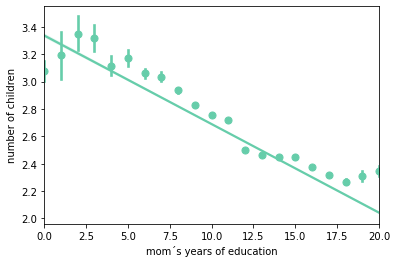

In [92]:
ax = sns.regplot(x="educm", y="KIDCOUNT", data=data_all_women_1980, x_estimator=np.mean, color="mediumaquamarine")
ax.set(xlabel='mom´s years of education', ylabel='number of children')
plt.show()

The plot above shows the relationship between mom's years of completed education and number of children. There is a clear negative correlation between years of schooling and total number of children ever had. According to Kim (2016), there exist a negative correlation between the level of women's education and fertility. Three mechanisms would influence fertility decisions of educated women: 1) relatively higher incomes; 2) positive health impacts of education increase children's survival rate and reduces the desire for more children; and 3) better educated women know better about the use of contraceptives, which reduces undesired births.

I explore this further by estimating a logit model that measures the probability of having more than 2 kids conditionally on women's education. The prediction equation is the following:

**Extension Equation (1):**
\begin{equation}
    log(\frac{p_i}{1-p_i}) = \phi_{0}\prime w_i + \theta_1 S_{1i} + \theta_2 S_{2i} + \gamma_1 educ \ mom_{i} +  \gamma_2 less \ grad_{i}  + \gamma_3 more \ grad_i + \varepsilon_i 
\end{equation}

where $p_i$ is the probability of having more than two children; $w_i$ is the vector of demographic variables; $S_{1i}$ and $S_{2i}$ are the indicators for boy first and boy second; $educ \ mom_i$ defines the total years of schooling of mom; $less \ grad_{i}$ defines women who did not finish school;  $more \ grad_i$ defines women who have more than a highschool degree; and $\gamma_1$,  $\gamma_2$, $\gamma_3$ are our parameters of interest.

In [51]:
def probability_childbearing(data, outcome):

    table = pd.DataFrame(
        {
            "Logit (1)": [],
            "Std.err (1)": [],
            "P-value (1)": [],

        }
    )
    table["Variables"] = Variables
    table = table.set_index("Variables")
    table
    
    for variable in Variables:
        
        logit_mod=sm_api.Logit(data[outcome], data[["educm", "lessgrad", "moregrad", "const", "AGEM", "agefstm", "boy1st", "boy2nd", "blackm", "hispm", "otheracem"]])
        logit_res = logit_mod.fit()


        outputs = [
                logit_res.params[variable],
                logit_res.bse[variable],
                logit_res.pvalues[variable],
        ]

        table.loc[variable] = outputs

    return table

In [52]:
Variables=["educm", "lessgrad", "moregrad"]
Table_prob_80=probability_childbearing(data_all_women_1980, "more2k")
Table_prob2_80=probability_childbearing(msample_1980, "more2k")
Table_prob80=pd.concat([Table_prob_80, Table_prob2_80], axis=1, keys=["All women 1980", "Married women 1980"])
Table_prob80

Optimization terminated successfully.
         Current function value: 0.627393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623245
         Iterations 5


All women 1980                            Married women 1980  \
               Logit (1) Std.err (1)    P-value (1)          Logit (1)   
Variables                                                                
educm          -0.062693    0.002671  8.207579e-122          -0.063175   
lessgrad        0.302645    0.011597  4.074515e-150           0.232035   
moregrad        0.134381    0.010735   5.950524e-36           0.235268   

                                     
          Std.err (1)   P-value (1)  
Variables                            
educm        0.003292  4.244501e-82  
lessgrad     0.015415  3.305115e-51  
moregrad     0.013384  3.610458e-69

The results above show the results for **Extension Equation (1)**. All the coefficients reported are statistically significant. The results show that women with less than a highschool degree are more likely to have a third child than women with more education. For the all women sample of 1980, the coefficient on $less \ grad$ is $0.3026$, which means that if a woman has not completed highschool, it could be expected that the log-odds of having a third child increase in $0.3026$. The coefficient for women with more than a highschool degree is still positive, but it is much smaller than the log-odds for less educated women. The coefficient on $educ \ mom$ reveals that an increase of 1 year of education leads to a decrease of $-0.062$ in the log-odds of having a third child.

An interesting finding is that the coefficients for less educated women and more educated women are virtually the same for the sample of married women for the 1980 census data. Here, both coefficients are around $0.23$. This suggest that married women do not vary their childbearing preferences as much as women in the full sample conditionally on their education level.


### Extension II: Causal Forest application for an alternative estimation of heterogeneity effects <a class="anchor" id="extension2"></a>

As part of the extension of the study of Angrist and Evans (1998), I want to explore the possible heterogeneous effects by applying a different methodology than the authors did and compare my results to the ones estimated in the original paper. For this, I use the Machine Learning (ML) method causal forest for estimating the Conditional Average Treatment Effect (CATE) for each subgroup of women's education: i) less educated women; ii) women with a high-school degree; iii) women with more tan a high-school degree. 

Angrist and Evans (1998) explore the heterogeneity of the treatment by using a multiple linear regression with iteration terms between the variable of interest and the treatment indicator, for example, the schooling level of women and same sex. The problem with this approach is that the number of parameters increase as one needs to include all the interacted and non-iteracted terms plus all the other explanatory variables. This could lead to potential computational issues. To overcome these challenges, a machine learning approach could handle big amounts of variables in a non-linear and iterative way.

The goal of a causal tree is to estimate the CATE:

$\hat{\tau(x)}= \mathbb{E}[Y_i(1)-Y_i(0)|X_i=x]$.

Here is the algorithm presented in Athey et al. (2019) for estimating treatment effects with causal forests:

-------------------------------------------------------------------------------------
##### Algorithm 1: Estimating treatment effects with causal forests as in Athey et al. (2019)
----------------------------------------------------------------------------------------



    Y.forest = regression_forest(X, Y, clusters = school.id)
    Y.hat = predict(Y.forest )$ predictions
    W.forest = regression_forest(X, W, clusters = school.id)
    W.hat = predict(W.forest )$ predictions
    cf.raw = causal_forest(X, Y, W,
                           Y.hat = Y.hat , W.hat = W.hat ,
                           clusters = school.id)

    varimp = variable_importance(cf.raw)
    selected.idx = which(varimp > mean(varimp ))
    
    cf = causal_forest(X[,selected.idx], Y, W,
                       Y.hat = Y.hat , W.hat = W.hat ,
                       clusters = school.id,
                       samples_per_cluster = 50,
                       tune.parameters = TRUE)
                       
    tau.hat = predict(cf)$ predictions

---------------------

where $\hat{\tau}$ is the estimated conditional average treatment effect. 

In an IV framework, the estimated conditional average treatment effect estimated by the forest is therefore:

$\hat{\tau(x)}= \frac{cov[Y,Z|X]}{cov[W,Z|X]} $.

where Y is the outcome variable, Z the instrument, W the treatment assignment. Notice that if Z and W coincide, then the instrumental causal forest is equivalent a normal causal forest.

For this application, since Angrist & Evans (1998) already identified that the treatment effect differs across education levels, I do not apply the algorithm to search for subgroups that differ but to calculate the CATE on the subgroups already identified by the authors. The following code is based on the **[python tutorial](https://towardsdatascience.com/causal-ml-for-data-science-deep-learning-with-instrumental-variables-96e5b7cc0482)** provided by Naushan (2021) who applies the ECONML package to the paper "Hard traveling" by Abrahams (2021) that estimates a causal forest in an IV framework and that is based on the algorithm proposed by Athey et al. (2019) for the general framework of treatment effects using causal forests.

#### 1. CATE estimations for subgroups on women's education <a class="anchor" id="extension2-1"></a>

The package ECONML allows for the calculation of the CATE as stated in Athey et al. (2019) and allows to expand it for a setting with unobserved confounders (IV causal forest). As an example, I walk through the code specifications for the sample of women with less than a high-school degree. For the other two subgroups, the code is basically the same.

First, I use the samples already constructed for each women's education level and split each sample into a train and test sample for the later estimation of the trees. I build the tree with a treatment variable of *more than 2 kids*, outcome of *worked for pay*, the vector of demographic covariates used by the authors thoughout the paper and *same sex* as instrumet. I set up W (here, controls for each sample) to zero.


In [37]:
#women with less education
train_01, test_01 = train_test_split(sample01, test_size=0.2)

treatment = ['more2k']
outcome = ['workedm']
covariates = ["AGEM", "agefstm", "boy1st", "boy2nd", "blackm", "hispm", "otheracem"]
instruments = ['same_sex']

Y_1 = train_01[outcome]
T_1 = train_01[treatment]
X_1 = train_01[covariates]
Z_1 = train_01[instruments]
X_test_1 = test_01[covariates]
W_1 = None

Then I build a IV Causal Random Forest by estimating honest trees with a minimun sample leaf number of 5. In terms of the number of trees estimated in each causal forest for each sample, these might vary depending on the subgroup for which the cate is estimated. The reason is computational problems regarding memory usage.

In [38]:
est_01 = CausalIVForest(criterion='het', 
                     n_estimators=1000,       
                     min_samples_leaf=5, 
                     max_depth=None, 
                     max_samples=0.5,
                     honest=True,
                     inference=True,
                     fit_intercept = True
                     )

est_01.fit(X_1, T_1, y=Y_1, Z=Z_1)

CausalIVForest(criterion='het', max_samples=0.5, n_estimators=1000)

After building the forest, I predict $\tau$ and also the confidence intervals. These results are computed for each indidividual in the sample (or subgroup) and storaged afterwards in a pandas dataframe. I sort the values of each CATE and plot them for visualization purposes.

In [39]:
treatment_effects_01, lb_01, ub_01 = est_01.predict(X_1, interval=True, alpha=0.05)

te_01 = []
for i in range(len(treatment_effects_01)):
    dict_te = {}
    dict_te['cate'] = treatment_effects_01[i][0]
    dict_te['lb'] = lb_01[i][0]
    dict_te['ub'] = ub_01[i][0]
    te_01.append(dict_te)
df_te_01 = pd.DataFrame(te_01)

df_te_01.sort_values('cate', inplace=True, ascending=True)
df_te_01.reset_index(inplace=True, drop=True)

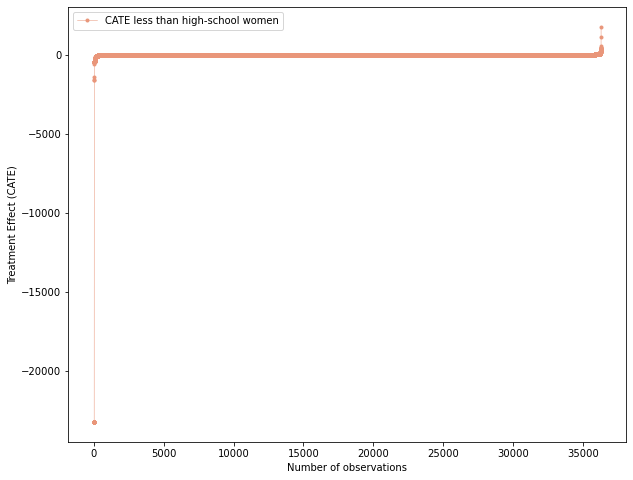

In [100]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df_te_01['cate'], marker='.', linestyle='-', linewidth=0.5, label='CATE less than high-school women', color='darksalmon')
ax.set_ylabel('Treatment Effect (CATE)')
ax.set_xlabel('Number of observations')
ax.legend()

The figure above shows some outliers for which the estimated treatment, in this case, the CATE, is extremly low or high. It is observed that the CATE concentrates around zero (which is in line with the estimates of Angrist and Evans (1998) for the mayority of the observations. In the figure below, I concentrate only on this specific area of interest of the CATE for the sample of women with less than a high-school degree. By zooming in, it is observed that the coefficients are mostly closed around zero, with a few observations having a lower or higher CATE. I also plot the confidence intervals that are shown in grey.

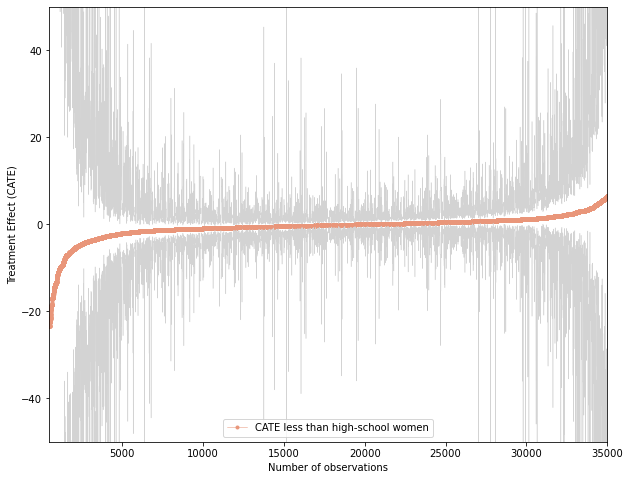

In [101]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df_te_01['cate'], marker='.', linestyle='-', linewidth=0.5, label='CATE less than high-school women', color='darksalmon')
ax.plot(df_te_01['lb'],linewidth=0.5, color='lightgrey')
ax.plot(df_te_01['ub'],linewidth=0.5, color='lightgrey')
ax.set_ylabel('Treatment Effect (CATE)')
ax.set_xlabel('Number of observations')
ax.legend()
plt.xlim([500, 35000])
plt.ylim([-50,50])
plt.show()

I repeat the procedure now for the other two samples: more educated women and women who graduated high-school only. As in the sample of less educated women, there seem to be some outlier observations for which the CATE is in the lower or upper tale of the distribution of the CATES. Again, I zoom in every graph to show that the estimates actually concentrate around zero. For these two subsamples, there are many more observations than with the sample of less educated women and therefore the condidence intervals seem to be more clustered together.

In [43]:
train_02, test_02 = train_test_split(sample02, test_size=0.2)

treatment = ['more2k']
outcome = ['workedm']
covariates = ["AGEM", "agefstm", "boy1st", "boy2nd", "blackm", "hispm", "otheracem", "total_incomed"]
instruments = ['same_sex']

Y_2 = train_02[outcome]
T_2 = train_02[treatment]
X_2 = train_02[covariates]
Z_2 = train_02[instruments]
X_test_2 = test_02[covariates]
W_2 = None

est_02 = CausalIVForest(criterion='het', 
                     n_estimators=500,       
                     min_samples_leaf=5, 
                     max_depth=None, 
                     max_samples=0.5,
                     honest=True,
                     inference=True,
                     fit_intercept = True
                     )

est_02.fit(X_2, T_2, y=Y_2, Z=Z_2)

treatment_effects_02, lb_02, ub_02 = est_02.predict(X_2, interval=True, alpha=0.05)

te_02 = []

for i in range(len(treatment_effects_02)):
    dict_te = {}
    dict_te['cate'] = treatment_effects_02[i][0]
    dict_te['lb'] = lb_02[i][0]
    dict_te['ub'] = ub_02[i][0]
    te_02.append(dict_te)
df_te_02 = pd.DataFrame(te_02)

df_te_02.sort_values('cate', inplace=True, ascending=True)
df_te_02.reset_index(inplace=True, drop=True)

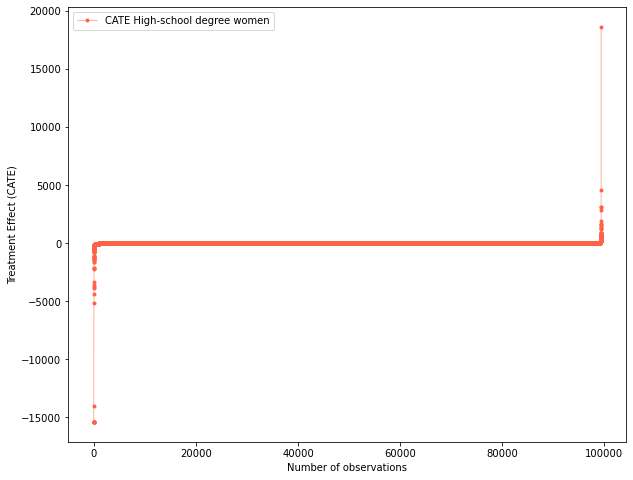

In [102]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df_te_02['cate'], marker='.', linestyle='-', linewidth=0.5, label='CATE High-school degree women', color='tomato')
ax.set_ylabel('Treatment Effect (CATE)')
ax.set_xlabel('Number of observations')
ax.legend()

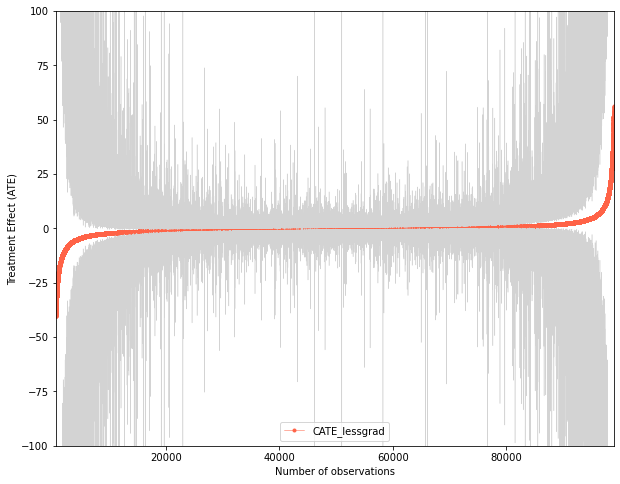

In [103]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df_te_02['cate'], marker='.', linestyle='-', linewidth=0.5, label='CATE_lessgrad', color='tomato')
ax.plot(df_te_02['lb'],linewidth=0.5, color='lightgrey')
ax.plot(df_te_02['ub'],linewidth=0.5, color='lightgrey')
ax.set_ylabel('Treatment Effect (ATE)')
ax.set_xlabel('Number of observations')
ax.legend()
plt.xlim([500, 99000])
plt.ylim([-100,100])
plt.show()

In [56]:
train_03, test_03 = train_test_split(sample03, test_size=0.2)

treatment = ['more2k']
outcome = ['workedm']
covariates = ["AGEM", "agefstm", "boy1st", "boy2nd", "blackm", "hispm", "otheracem", "total_incomed"]
instruments = ['same_sex']

Y_3 = train_03[outcome]
T_3 = train_03[treatment]
X_3 = train_03[covariates]
Z_3 = train_03[instruments]
X_test_3 = test_03[covariates]
W_3 = None

est_03 = CausalIVForest(criterion='het', 
                     n_estimators=500,       
                     min_samples_leaf=5, 
                     max_depth=None, 
                     max_samples=0.5,
                     honest=True,
                     inference=True,
                     fit_intercept = True
                     )

est_03.fit(X_3, T_3, y=Y_3, Z=Z_3)

treatment_effects_03, lb_03, ub_03 = est_03.predict(X_3, interval=True, alpha=0.05)

te_03 = []

for i in range(len(treatment_effects_03)):
    dict_te = {}
    dict_te['cate'] = treatment_effects_03[i][0]
    dict_te['lb'] = lb_03[i][0]
    dict_te['ub'] = ub_03[i][0]
    te_03.append(dict_te)
df_te_03 = pd.DataFrame(te_03)

df_te_03.sort_values('cate', inplace=True, ascending=True)
df_te_03.reset_index(inplace=True, drop=True)

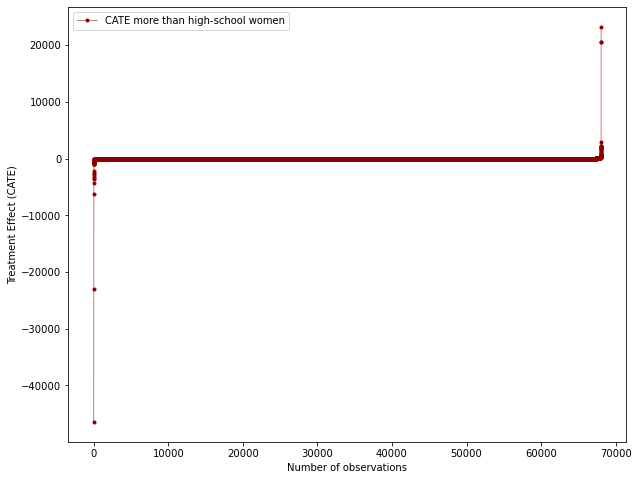

In [104]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df_te_03['cate'], marker='.', linestyle='-', linewidth=0.5, label='CATE more than high-school women', color='darkred')
ax.set_ylabel('Treatment Effect (CATE)')
ax.set_xlabel('Number of observations')
ax.legend()

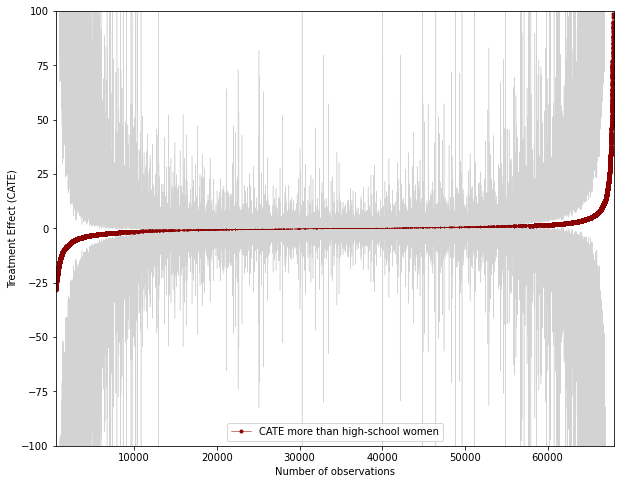

In [105]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df_te_03['cate'], marker='.', linestyle='-', linewidth=0.5, label='CATE more than high-school women', color='darkred')
ax.plot(df_te_03['lb'],linewidth=0.5, color='lightgrey')
ax.plot(df_te_03['ub'],linewidth=0.5, color='lightgrey')
ax.set_ylabel('Treatment Effect (CATE)')
ax.set_xlabel('Number of observations')
ax.legend()
plt.xlim([500, 68000])
plt.ylim([-100,100])
plt.show()

#### 2. Simulations to show convergence of the estimations of the CATE  <a class="anchor" id="extension2-2"></a>

Since it iteration of the code above for the casual forest provides a slighly different estimation of the average CATE, I estimate each causal forest 20 times. Note that the estimation of the forest provides an estimated CATE for each observation (i.e., individual in the sample) and these individual estimations were plotted before. However, as discussed previously, there might seem to be some observations for which the CATE is exxagerated (and I called them possible outliers).

To account for this, after the estimation of each forest in a for-loop that estimates 20 causal forests for each subsample, I take the **median value** of the CATE for each forest and storage it in a pandas dataframe. After having the 20 estimates CATE median values, I estimate the CATE of each subsample as the mean value of these 20 coefficients following Naushan (2021).

---
<span style="color:coral">**Note**:</span> The computation of these simulations take approximatly between 16 to 60 minutes, depending on the subsample used for the estimations and the number of trees used in the forest. An obstacle encountered is that the computation of results that take multiple minutes is not supported by [GitHub Actions CI](https://docs.github.com/en/actions) and I presented runtime issues while processing the notebook. In order to tacke this problem, I  pickled the dataframes with the final results and storaged them in the folder *simulation results* of this repository. The code for the simulations is presented inside markdown cells for later reproducibility.

---

**Results for women with less than a high-school degree**

```python
i=0

storage={}
matriz=[]
while i<20:

    est_i = CausalIVForest(criterion='het', 
                         n_estimators=5000,       
                         min_samples_leaf=5, 
                         max_depth=None, 
                         max_samples=0.5,
                         honest=True,
                         inference=True,
                         fit_intercept = True
                         )

    est_i.fit(X_1, T_1, y=Y_1, Z=Z_1)
    
    treatment_effects_i, lb_i, ub_i = est_i.predict(X_1, interval=True, alpha=0.05)

    te_j = []
    
    for j in range(len(treatment_effects_i)):
        dict_te = {}
        dict_te['cate'] = treatment_effects_i[j][0]
        dict_te['lb'] = lb_i[j][0]
        dict_te['ub'] = ub_i[j][0]
        te_j.append(dict_te)
    df_te_i = pd.DataFrame(te_j)
    
    storage=df_te_i["cate"].median()
    matriz.append(storage)
    df_final_1=pd.DataFrame(matriz)
    
    i += 1
    
pickle.dump(df_final_1, open("simulation_results/df_final_1.p", "wb" ))
```

In [10]:
results_lessgrad = pickle.load( open("simulation_results/df_final_1.p", "rb" ))

In [11]:
results_lessgrad.mean()

0   -0.114116
dtype: float64

**Results for women with a high-school degree**

```python
i=0

storage={}
matriz=[]
while i<20:

    est_i = CausalIVForest(criterion='het', 
                         n_estimators=1000,       
                         min_samples_leaf=5, 
                         max_depth=None, 
                         max_samples=0.5,
                         honest=True,
                         inference=True,
                         fit_intercept = True
                         )

    est_i.fit(X_2, T_2, y=Y_2, Z=Z_2)
    
    treatment_effects_i, lb_i, ub_i = est_i.predict(X_2, interval=True, alpha=0.05)

    te_j = []
    
    for j in range(len(treatment_effects_i)):
        dict_te = {}
        dict_te['cate'] = treatment_effects_i[j][0]
        dict_te['lb'] = lb_i[j][0]
        dict_te['ub'] = ub_i[j][0]
        te_j.append(dict_te)
    df_te_i = pd.DataFrame(te_j)
    
    storage=df_te_i["cate"].median()
    matriz.append(storage)
    df_final_2=pd.DataFrame(matriz)
    
    i += 1
    
pickle.dump(df_final_2, open("simulation_results/df_final_2.p", "wb" ))
```

In [12]:
results_hsgrad = pickle.load( open("simulation_results/df_final_2.p", "rb" ))

In [14]:
results_hsgrad.mean()

0   -0.173842
dtype: float64

**Results for women with more than a high-school degree**

```python
i=0

storage={}
matriz=[]
while i<20:

    est_i = CausalIVForest(criterion='het', 
                         n_estimators=1000,       
                         min_samples_leaf=5, 
                         max_depth=None, 
                         max_samples=0.5,
                         honest=True,
                         inference=True,
                         fit_intercept = True
                         )

    est_i.fit(X_3, T_3, y=Y_3, Z=Z_3)
    
    treatment_effects_i, lb_i, ub_i = est_i.predict(X_3, interval=True, alpha=0.05)

    te_j = []
    
    for j in range(len(treatment_effects_i)):
        dict_te = {}
        dict_te['cate'] = treatment_effects_i[j][0]
        dict_te['lb'] = lb_i[j][0]
        dict_te['ub'] = ub_i[j][0]
        te_j.append(dict_te)
    df_te_i = pd.DataFrame(te_j)
    
    storage=df_te_i["cate"].median()
    matriz.append(storage)
    df_final_3=pd.DataFrame(matriz)
     
    i += 1

pickle.dump(df_final_3, open("simulation_results/df_final_3.p", "wb" ))
```

In [15]:
results_moregrad = pickle.load( open("simulation_results/df_final_3.p", "rb" ))

In [16]:
results_moregrad.mean()

0   -0.08808
dtype: float64

#### 3. Discussion of the results and comparison to Angrist and Evans (1998) <a class="anchor" id="extension2-3"></a>

The results of the CATE for the subgroups are the following: i) the effect of having a third child on the probability of worked for pay for married women who did not receive a high-school diploma is $-0.114$, which means that less educated women with less than a high-school degree are around $11.4$ percentage points less likely to work for pay; ii) the effect of childbearing on married women with a high-school degree on worked for pay is the highest, where these women are $17.3$ percentage points less likely to work if they have a third child; and iii) the effect of an increase in family size for women with more than a high-school degree is low for women with more level of schooling, where they are only $8.8$ percentage points less likely to work for pay.

These results can be compared to the 2SLS estimates in Angrist and Evans (1998) Table 9 Panel B for the outcome *worked for pay*. The following table summarizes the results when using causal forests to estimate the CATE for these subgroups and the estimates found by the authors where they use 2SLS with iteraction terms to estimate the LATE:

| Subgroup                       | 2SLS Angrist and Evans (1998)     | Causal Forest            |
| :----                          | :----                             |:----                     |
| Married women < high-school    | -0.121                            | -0.114                   |
| Married women = high-school    | -0.147                            | -0.173                   |                   
| Married women > high-school    | -0.082                            | -0.088                   |            


The results of the CATE using causal forests are very similar to the results estimated by Angrist and Evans (1998) using 2SLS with iteration terms for the married women with less than a high-school degree and married women with more education than a high-school diploma. For this later subgroup, the causal forest estimation agrees with the findings on the main paper that that the effect of childbearing on women with more schooling is higher than the rest of the subgroups. The estimate for the married women with a high-school degree using causal forest seems to be larger than the estimate using 2SLS.

One of the disadvantage of the results showed here is that for the causal forest estimations the standard errors are not visible (before I computed only the confidence intervals for the individual CATES). This makes it difficult to compare the results and to evaluate which approach is more efficient in computing the treatment effects for each subgroup. However, the aim of my excersice was to implement a novel machile learning technique applied to the quantification of causal effects and the similar results to Angrist and Evans (1998) suggest that the causal forest perform well. 

### Extension III: Testing for selection on unobservables or "violation of exclusion restriction" <a class="anchor" id="extension3"></a>

Black et al. (2015) develop a simple framework for testing on selection on unobserved variables. The authors argue that researchers tend to invoke the Conditional Independence Assumptions (CIA) without testing them in a formal manner. The CIA assumptions under a LATE framework (i.e., IV approach) gives the VIA assumptions (as in Vytlacil-Imbens-Angrist). The following are the conditions:

Condition 1: Existence of Instrument
\begin{equation}
    (Y_{0i}, Y_{1i}, {D(z)|z \in \mathbb{Z} }) {\perp\!\!\!\perp} Z|X \ and \ Pr(D=1|x, Z=z) \ is \ a \ non \ trivial \ function \ of \ z  
\end{equation}

Condition 2: Monotonicity
\begin{equation}
    \forall z^0, z^1 \ \in \mathbb{Z}, \ either \ D_i(z^0)\geq  D_i(z^1) \forall i \ or \ D_i(z^0)\leq  D_i(z^1) \forall i
\end{equation}

The test is given as follows. For the case with a single binary instrument we would like to estimate:

Equation (A)
\begin{equation}
    E(Y_{1i}|D_i=1)=X_i \beta_1 + \alpha_1 Z_i
\end{equation}

Equation (B)
\begin{equation}
    E(Y_{0i}|D_i=0)=X_i \beta_0 + \alpha_0 Z_i
\end{equation}

We use equation A using the sample of treated observations to test:

\begin{equation}
    \ H^0: CIA^1 \ holds, \ or \ \alpha_1=0
\end{equation}

\begin{equation}
    \ H^A: CIA^1 \ not \ holds, \ or \ \alpha_1 \neq 0
\end{equation}

Similarly, we use equiation B using the sample of untreated observations to test:

\begin{equation}
    \ H^0: CIA^0 \ holds, \ or \ \alpha_0=0
\end{equation}

\begin{equation}
    \ H^A: CIA^0 \ not \ holds, \ or \ \alpha_0 \neq 0
\end{equation}

Recall the definitions of the groups of individuals within the LATE framework exposed before on this notebook. The intuition of the test is that equation A compares $E(Y_1|x, A)$ to $E(Y_1|x, C)$, where A stands for *Always Takers* and C for *Compliers*. On the other hand, equation B will compare $E(Y_1|x, NT)$ to $E(Y_1|x, C)$, where NT is for *Never Takers*. The finding that either $\alpha_0 \neq 0$ or $\alpha_1 \neq 0$ constitutes evidence either of selection or of the violation of the exclusion restriction (i.e., Condition 1).

In the context of Angrist and Evans (1998), I estimate the parametric approach proposed by Black (2015):

\begin{equation}
    y_0i = \beta_0' w_i + \alpha_0 \ same_sex_i + \varepsilon_i 
\end{equation}

\begin{equation}
    y_1i = \beta_1' w_i + \alpha_1 \ same_sex_i + \varepsilon_i 
\end{equation}

I estimate these equations for the outcomes of worked for pay, weeks worked, hours woked, total income, family income and non wife income for both the sample of all women and married women of the 1980 census data.

In [53]:
sample_untreat_80=data_all_women_1980[data_all_women_1980["KIDCOUNT"]==2]
sample_treat_80=data_all_women_1980[data_all_women_1980["KIDCOUNT"]>2]

In [54]:
sample_untreat_m_80=msample_1980[msample_1980["KIDCOUNT"]==2]
sample_treat_m_80=msample_1980[msample_1980["KIDCOUNT"]>2]

In [69]:
def CIA_Test(data, data2, instrument, outcomes):

    table = pd.DataFrame(
        {
            "OLS (Y_1)": [],
            "P-Value (Y_1)": [],
            "OLS (Y_0)": [],
            "P-value (Y_0)": [],
        }
    )
    
    table["outcomes"] = outcomes
    table = table.set_index("outcomes")

    for outcome in outcomes:

        data=data
        model_OLS_Y0=sm_api.OLS(data[outcome], sm_api.add_constant(data[[instrument, "boy1st", "boy2nd", "AGEM", 'agefstm', "blackm", "hispm", "otheracem"]]))
        result_OLS_Y0=model_OLS_Y0.fit()
        model_OLS_Y1=sm_api.OLS(data2[outcome], sm_api.add_constant(data2[[instrument, "boy1st", "boy2nd", "AGEM", 'agefstm', "blackm", "hispm", "otheracem"]]))
        result_OLS_Y1=model_OLS_Y1.fit()        
        
        outputs = [
                result_OLS_Y0.params[instrument],
                result_OLS_Y0.pvalues[instrument],
                result_OLS_Y1.params[instrument],
                result_OLS_Y1.pvalues[instrument],
        ]
        
        table.loc[outcome] = outputs
        table = table.round(4)

    return table

In [70]:
outcomes1=["workedm", "WEEKSM", "HOURSM", "total_incomem"]
outcomes2=["workedm", "WEEKSM", "HOURSM", "total_incomem", "faminc_log", "nonmomi_log"]
Table_CIAtest_1=CIA_Test(sample_treat_80, sample_untreat_80, "same_sex", outcomes1)
Table_CIAtest_2=CIA_Test(sample_treat_m_80, sample_untreat_m_80, "same_sex", outcomes2)
Table_CIAtest_1980=pd.concat([Table_CIAtest_1, Table_CIAtest_2], axis=1, 
                             keys=["All women-same sex", "Married women-same sex"])

In [72]:
Table_CIAtest_1980

All women-same sex                                        \
                       OLS (Y_1) P-Value (Y_1) OLS (Y_0) P-value (Y_0)   
workedm                   0.0020        0.4241    0.0047        0.0174   
WEEKSM                    0.0684        0.5114    0.2992        0.0009   
HOURSM                    0.0060        0.9485    0.2061        0.0062   
total_incomem            -0.6626        0.9890  188.5705        0.0000   
faminc_log                   NaN           NaN       NaN           NaN   
nonmomi_log                  NaN           NaN       NaN           NaN   

              Married women-same sex                                        
                           OLS (Y_1) P-Value (Y_1) OLS (Y_0) P-value (Y_0)  
workedm                       0.0021        0.5129    0.0042        0.0866  
WEEKSM                        0.0876        0.5006    0.2522        0.0210  
HOURSM                       -0.0024        0.9831    0.1310        0.1460  
total_incomem                53.7750        0.3549  175.4067        0.0009  
faminc_log                    0.0177        0.0163   -0.0003        0.9569  
nonmomi_log                   0.0196        0.0215   -0.0013        0.8301

Black et al (2015) apply this test for the samples of Angrist and Evans (1998) for the all women sample. The results shown in the table above match the findings of Black et al (2015) and suggest that the data strongly rejects the null hypothesis when estimating equation B (or the CIA on the untreated sample) at a 5% confidence level. According to the authors, there is evidence of selection on unobservables and the fact that $ \alpha_0$ is positive suggest that the group of compliers have higher probabilities or worked for pay, weeks worked, hours worked and income than the never takers.

However, when estimating equation A, the data cannot reject the null hypothesis. The coefficients are statistically insignificant and small. Thus, the authors do not find evidence of selection on unobservables for the missing counterfactual $Y_1$. The authors find this results very surprising, since they expected a two-sided selection problem.

I apply the test to the married women sample of 1980. In this case, the results are somehow mixed. When estimating the missing counterfactual for $Y_0$, the null hypothesis cannot be rejected for the coefficients on hours worked, family income and non-wife income. The coefficient of worked for pay can be rejected at a 10% confidence interval and the coefficient of weeks worked can be rejected at a 5% confidence interval. For the missing counterfactual $Y_1$, the null hypothesis can be rejected in every case except for family income and non wife income.

My results for the married sample suggest that there could be selection on unobservables for both compliers-never takers and compliers-always takers, although the results are somehow ambiguos. 

# Conclusions <a class="anchor" id="conclusions"></a>

Angrist and Evans (1998) present a novel estrategy to measure the causal effect of fertility on labor supply by using the instrument of same sex. The findings of the paper is that IV estimates statistically significant and smaller than OLS, suggesting that OLS might exaggerate the effect of childbearing on labor-supply outcomes. For samples of all women and married women, the estimated coefficients of having a third child are negative, which suggest that childbearing has a negative effect on labor-supply. Also, they estimate heterogeneous effects by estimating models with interactions between the instrument and the variable of interest; in this case, women's schooling level and husband's earnings.

The results presented in this replication are very similar to the ones presented in the original paper, except for Table 4 (difference in means) and Table 9 and 10 (for the models with the interaction terms), for which the estimates vary a little. This could be due for several reasons. One of the main reasons is that I could have constructed the samples in a different way as the authors did (especially with the splitting of the husband's earnings distribution). Also, there is a mismatch between the number of observations in the log-file published by the authors and the number of observations reported in their paper, which could have somehow make the estimations vary (more when these dropped observations represent outliers). 

Other reasons for different estimation results might be software-related (but only for extremly small difference in estimates, as presented in general in this replication). I have encountered replications of Angrist and Evans (1998) in both R and Stata, for which the results present a very small variation as well. In this case, an explanation could be that the numerical methods for OLS, 2SLS, etc, are sensitive to rounding errors and thus, different numerical methods might estimate slightly different numbers. In the case of Angrist and Evans (1998), the authors use SAS for the computation of numerical results. R, Stata, Python and SAS might differ in terms of numerical methods.

The results of the extensions on Angrist and Evans (1998) proposed in this replication excercise provided interesting results. First, it was shown by using a logit model that with more years of schooling, the probability of having more than  two children fall for the sample of all women 1980. In contrast, the probability of having a third kid was virtually the same for less and more educated women for the sample of married women 1980.

Applying a ML method (causal forest) to estimate the effect of fertility on labor supply for women condition on their level of education confirmed that the effect is less severe for more educated women, while it is larger for women with less years of schooling. Moreover, the estimates of the CATE using causal forests are very similar to the ones on Angrist and Evans (1998), who used multiple linear regression with iteration terms.

Finally, I applied a test provided by Black et al (2015), replicated their results applied to Angrist and Evans (1998) and expand their results by applying the test to the married women sample 1980. For all the women sample, the test suggests that there might be selection on unobservables for the missing counterfactual $Y_0$, while there is no evidence for the case of $Y_1$. For the married sample, the results are mixed and ambigous, since some labor supply variables seem to present selection on unobsrvables while others don't.

# Apendix: Variable Dictionary <a class="anchor" id="apendix"></a>

### Census Extracts 1980 and 1990

| **Variable**    | **Description**                                                          |
|-----------------|--------------------------------------------------------------------------|
| KIDCOUNT        | children ever born in a household                                        |
| more2k          | ethnicity, 1 for white and 2 for nonwhite                                |
| boy1st          | 1 if first child was a boy; 0 otherwise                                  |
| boy2nd          | 1 if second child was a boy; 0 otherwise                                 |
| two_boys        | 1 if first two children were boys; 0 otherwise                           |
| two_girls       | 1 if first two children were girls; 0 otherwise                          |
| same_sex        | 1 if first two children were the same sex                                |
| twin            | 1 if second birth was a twin                                             |
| AGEM            | Age of mom (in years                                                     |
| AGED            | Age of dad (in years)                                                    |
| agefstm         | Age of first birth mom                                                   |
| agefstd         | Age of first birth dad                                                   |
| workedm         | 1 if worked for pay in year prior to the census-mom                      |
| workedd         | 1 if worked for pay in year prior to the census-dad                      |
| WEEKSM          | Weeks worked in year prior to the census-mom                             |
| WEEKSD          | Weeks worked in year prior to the census-dad                             |
| HOURSM          | Average hours worked per week-mom                                        |
| HOURSD          | Average hours worked per week-dad                                        |
| total_incomem   | Labor earnings year prior to census, 1995 dollars-mom                    |
| total_incomed   | Labor earnings year prior to census, 1995 dollars-dad                    |
| faminc          | Family income year prior to census, 1995 dollars                         |
| total_incomem   | Labor earnings year prior to census, 1995 dollars                        |
| nonmomi         | Non-wife income                                                          |
| educm           | Years of mom's schooling (1980 data)                                     |
| YEARSCH         | Years of mom's schooling (1990 data)                                     |
| lessgrad        | 1 if woman has less than a highschool degree; 0 otherwise                |
| hsgrad          | 1 if a woman has highschool degree; 0 otherwise                          |
| moregra         | 1 if a woman has more than a highschool degree; 0 otherwise              |

-------
Notebook by Carolina Alvarez | GitHub profile: https://github.com/carolinalvarez.

---

# References 

* **Angrist, J., & Evans, W. (1998)**. *[Children and Their Parents' Labor Supply: Evidence from Exogenous Variation in Family Size](https://www.jstor.org/stable/116844)*, 88(3), The American Economic Review.



* **Athey, S., and Wager, S. (2019).** *[Estimating treatment effects with causal forests: An application](https://muse.jhu.edu/article/793356/summary)*. Observational Studies, 5(2), 37-51.


* **Black, D., Joo, J., Lalonde, R., Smith, J., Taylor, E. (2015)**. *[Simple Test for SelectionB Bias: Learning more from instrumental variables](http://ftp.iza.org/dp9346.pdf)*. IZA Discussion Papers 9346, Institute of Labor Economics (IZA).


* **Cunningham, S. (2021)**. [Causal Inference: The Mixtape](https://www.scunning.com/mixtape.html#:~:text=Causal%20Inference%3A%20The%20Mixtape.%20An%20accessible%2C%20contemporary%20introduction,allow%20social%20scientists%20to%20determine%20what%20causes%20what.). *Yale University Press* 


* **Naushan, H. (2021)**. [Causal ML for Data Science: Deep Learning with Instrumental Variables](https://towardsdatascience.com/causal-ml-for-data-science-deep-learning-with-instrumental-variables-96e5b7cc0482). Towards Data Science-Blog.


* **Stoffi, F., and Gnecco, G. (2019).** *[Estimating heterogeous causal effects in the presence of Irregular assignment mechanisms](https://arxiv.org/pdf/1808.04281.pdf)*. arXiv:1808.04281


* **Winship, C., & Morgan, S. L. (2007).** Counterfactuals and causal inference: Methods and principles for social research. *Cambridge, England: Cambridge University Press.*